# Graph: Prio
This uses the pkl outputs from the salabim and slurmtrain notebooks

## TODO: 
- [x] Reimport after run6 rerun!
- Other
    - [ ] Add diag_start and diag_end creation to run_job_trace script
    - [ ] Automate X_batch salabim model
    - [ ] Automate X_batch slurmtrain data

In [72]:
import numpy as np
import pandas as pd
from pathlib import Path
from scipy import stats
import re
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [73]:
import matplotlib.pylab as pylab

# size: Either a relative value of 'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large' 
#     or an absolute font size, e.g., 10. Default: rcParams["font.size"] (default: 10.0)

params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [74]:
# Setup Paths
path_slurmtrain = Path(r"/home/overlytic/thesis/notebooks/slurm_train/output/sacct")
path_slurmsim = Path(r"/mnt/wsl/instances/Ubuntu-18.04//home/slurm/slurm_sim_ws/slurm_sim_tools/slurm_batches/simple_traces/srun")

In [75]:
# Parameters

myrun_short_id = "2jt-run30-rho60-n500"

## Base run 
myrun_type0 = "fiforun"
myrun_shortname0 = f"{myrun_type0}_{myrun_short_id}"

## Main run
myrun_type = "priorun"
myrun_shortname = f"{myrun_type}_{myrun_short_id}"

print(f"myrun_shortname0: {myrun_shortname0}")
print(f"myrun_shortname: {myrun_shortname}")

## General Param
save_csv = True
clear_big_dict = False

# Main Metrics for 'wait table all metrics'
metrics = ['min', 'max',  'std', 'mean']
metric_names = ['min', 'max', '$s_{dev}$', 'average']

myrun_shortname0: fiforun_2jt-run30-rho60-n500
myrun_shortname: priorun_2jt-run30-rho60-n500


In [76]:
# myrun_savepath = Path('.') / myrun_type / myrun_shortname
# print(f"Output folder: {myrun_savepath}")

In [77]:
# Paths
thesis_path = Path(".")
save_image_path = thesis_path / "images" / "results"
save_data_path = thesis_path / "images" / "data"

In [78]:
# Helper functions

def extract_run_num(f, run_type):
    """
    f : string filename e.g. srun8_fiforun_2jt-run30-rho60-run10_slurmtrain_dfacct
    Result : '10' on error return -1
    """
    run_search = re.search(f".*-run(.*)_{run_type}.*.pkl", f)
    
    run = -1 # default
    
    if run_search:
        srun = run_search.group(1)
        
        if srun.isdigit():
            run = int(srun)
        
    return run
    

In [79]:
# write the above as a function ... quickly ... 
def load_run_filelist(myrun_shortname, myrun_model, myrun_filename, folder_path=save_data_path, sort=True, return_detail=False):
    
    file_search_string = f'*{myrun_shortname}*{myrun_model}*{myrun_filename}'
    filelist_all = list(folder_path.glob(file_search_string))

    if filelist_all:
        # Extract run numbers
        run_nums_all = [extract_run_num(p.name, myrun_model) for p in filelist_all]
        
        if sort: 
            # Sort paths based on valid run numbers
            ind_sort = np.argsort(run_nums_all)
            ind_sort_valid = [ind_sort[i] for i, value in enumerate(run_nums_all) if value > 0]
            run_nums_sorted = [run_nums_all[i] for i in ind_sort_valid]
            filelist_sorted = [filelist_all[i] for i in ind_sort_valid]
                        
            if return_detail:
                return filelist_sorted, run_nums_sorted, file_search_string  
            else:
                return filelist_sorted
        
        else:
            if return_detail:
                return filelist_all, run_nums_all, file_search_string 
            else: 
                return filelist_all
        
    else:
        
        if return_detail:
            return [], [], file_search_string
        else: 
            return []

In [80]:
# Example for laoding runs:
strain_dfacct_sorted, strain_run_nums, strain_search_string = load_run_filelist(myrun_shortname, "slurmtrain", "dfacct.pkl", return_detail=True)

if strain_dfacct_sorted: 
    print(f"slurmtrain runs count: {len(strain_run_nums)}")
    print(f"slurmtrain run nums: {strain_run_nums}")
    for x in strain_dfacct_sorted: print(x)
else: 
    print(f"No files found for search string: {strain_search_string}\n in path: {save_data_path.absolute()}")

slurmtrain runs count: 10
slurmtrain run nums: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
images/data/srun8_priorun_2jt-run30-rho60-n500-run1_slurmtrain_dfacct.pkl
images/data/srun8_priorun_2jt-run30-rho60-n500-run2_slurmtrain_dfacct.pkl
images/data/srun8_priorun_2jt-run30-rho60-n500-run3_slurmtrain_dfacct.pkl
images/data/srun8_priorun_2jt-run30-rho60-n500-run4_slurmtrain_dfacct.pkl
images/data/srun8_priorun_2jt-run30-rho60-n500-run5_slurmtrain_dfacct.pkl
images/data/srun8_priorun_2jt-run30-rho60-n500-run6_slurmtrain_dfacct.pkl
images/data/srun8_priorun_2jt-run30-rho60-n500-run7_slurmtrain_dfacct.pkl
images/data/srun8_priorun_2jt-run30-rho60-n500-run8_slurmtrain_dfacct.pkl
images/data/srun8_priorun_2jt-run30-rho60-n500-run9_slurmtrain_dfacct.pkl
images/data/srun8_priorun_2jt-run30-rho60-n500-run10_slurmtrain_dfacct.pkl


# Load Run File List

## SlurmTrain

### FIFO Runs (for reference)

In [81]:
strain_fifo_dfacct_sorted = load_run_filelist(myrun_shortname0, "slurmtrain", "dfacct.pkl")
strain_fifo_dfpetime_sorted = load_run_filelist(myrun_shortname0, "slurmtrain", "dfpetime.pkl")

print(f"strain_fifo_dfacct_sorted: {len(strain_fifo_dfacct_sorted)}")
print(f"strain_fifo_dfacct_sorted: {len(strain_fifo_dfacct_sorted)}")

strain_fifo_dfacct_sorted: 10
strain_fifo_dfacct_sorted: 10


### BF Runs

In [82]:
strain_prio_dfacct_sorted = load_run_filelist(myrun_shortname, "slurmtrain", "dfacct.pkl")
strain_prio_dfpetime_sorted = load_run_filelist(myrun_shortname, "slurmtrain", "dfpetime.pkl")
strain_prio_dictbackfill_sorted = load_run_filelist(myrun_shortname, "slurmtrain", "dictbackfill.pkl")

print(f"strain_prio_dfacct_sorted: {len(strain_prio_dfacct_sorted)}")
print(f"strain_prio_dfpetime_sorted: {len(strain_prio_dfpetime_sorted)}")
print(f"strain_prio_dictbackfill_sorted: {len(strain_prio_dictbackfill_sorted)}")

strain_prio_dfacct_sorted: 10
strain_prio_dfpetime_sorted: 10
strain_prio_dictbackfill_sorted: 0


## Salabim

### FIFO Runs (for reference)

In [83]:
sala_fifo_dfjobs_sorted = load_run_filelist(myrun_shortname0, "salabim", "dfjobs.pkl")
sala_fifo_dfpetime_sorted = load_run_filelist(myrun_shortname0, "salabim", "dfpetime.pkl")

print(f"sala_fifo_dfjobs_sorted: {len(sala_fifo_dfjobs_sorted)}")
print(f"sala_fifo_dfpetime_sorted: {len(sala_fifo_dfpetime_sorted)}")

sala_fifo_dfjobs_sorted: 10
sala_fifo_dfpetime_sorted: 10


### Prio Runs

In [84]:
sala_prio_dfjobs_sorted = load_run_filelist(myrun_shortname, "salabim", "dfjobs.pkl")
sala_prio_dfpetime_sorted = load_run_filelist(myrun_shortname, "salabim", "dfpetime.pkl")

print(f"sala_prio_dfjobs_sorted: {len(sala_prio_dfjobs_sorted)}")
print(f"sala_prio_dfpetime_sorted: {len(sala_prio_dfpetime_sorted)}")

sala_prio_dfjobs_sorted: 10
sala_prio_dfpetime_sorted: 10


# Load Runs

In [85]:
def calc_strain_wait(sacct_df):
    
    sacct_df.pe_req = sacct_df.pe_req.round(0).astype(int)
    
    wait_table = (sacct_df
     .loc[:, ['Account', 'JobName', 'pe_req', 'wait_time', 'elapsed_time']]
     .assign(job_prio =
             lambda x: np.select([x.Account == "training", x.Account=="crucial"],
                                 [1, 10]))
     .rename(columns = {'elapsed_time':'run_time',
                        'pe_req': 'job_pe_req',
                        'JobName' : 'job_number'})
     .groupby(['job_prio', 'job_pe_req'])
#       .groupby(['job_prio'])
      .agg({
           "wait_time": ["mean"],
           "run_time" : ["mean"],
           "job_number" : ["count"] #,
           # "backfill" : ["sum"]
            })
     .reset_index()
    )
    
    wait_table.columns = wait_table.columns.map("_".join).str.strip('_')
    
    return wait_table

# # # Test:
# sacct_df = pd.read_pickle(strain_dfacct_sorted[0], compression='infer')
# w_strain = calc_strain_wait(sacct_df)
# w_strain

In [86]:
def calc_sala_wait(df_jobs):
    
    df_jobs.job_pe_req = df_jobs.job_pe_req.round(0).astype(int)
    
    wait_table = (df_jobs
    #      .merge(df_job_idx, on="job_name", how="inner")
                  .loc[:, ['job_number', 'job_pe_req', 
                           'job_prio', 'wait_time', 'run_time', 
                           'backfill']]
                   .groupby(['job_prio', 'job_pe_req'])
#                   .groupby(['job_prio'])                  
                  .agg({
           "wait_time": ["mean"],
           "run_time" : ["mean"],
#            "job_pe_req" : ["mean"],
           "job_number" : ["count"],
           "backfill" : ["sum"]
            })
     .reset_index())

    wait_table.columns = wait_table.columns.map("_".join).str.strip('_')

    return(wait_table)
    
# # Test
# df_jobs = pd.read_pickle(salabim_dfjobs_sorted[0])
# w_sala = calc_sala_wait(df_jobs)
# w_sala

## SlurmTrain Runs

In [87]:
# Read SlurmTrain FIFO Runs and make table with wait times

strain_fifo_lst_wait = []

num_runs = len(strain_fifo_dfacct_sorted)

load_bf = False
list_sacct = strain_fifo_dfacct_sorted
list_petime = strain_fifo_dfpetime_sorted
list_bf = None

dic_st_fifo_sacct = {}
dic_st_fifo_petime = {}
dic_st_fifo_bfdata = None

for i in range(num_runs):
    
    # SAcct
    sacct_path = list_sacct[i]
    df_sacct = pd.read_pickle(sacct_path)
    dic_st_fifo_sacct[i] = df_sacct
    
    # PE Time
    petime_path = list_petime[i]
    df_petime = pd.read_pickle(petime_path)    
    dic_st_fifo_petime[i] = df_petime
    
    # Calc Wait Time
    strain_wait = calc_strain_wait(df_sacct)

    # BF Info
    if load_bf:
        bf_path = list_bf[i]
        dic_bf = pd.read_pickle(bf_path)
        dic_st_fifo_bfdata[i] = dic_bf
        strain_wait['Total_run_backfills'] = dic_bf['backfill_count']
    else: 
        strain_wait['Total_run_backfills'] = 0
    
    # Other Info
    strain_wait['RunNum'] = i+1
    strain_wait['RunType'] = 'slurmtrain'
    strain_wait['SchedType'] = 'FIFO'
    
    
    strain_fifo_lst_wait.append(strain_wait)
    
df_wait_fifo_strain = pd.concat(strain_fifo_lst_wait)

df_wait_fifo_strain.head(10)

,job_prio,job_pe_req,wait_time_mean,run_time_mean,job_number_count,Total_run_backfills,RunNum,RunType,SchedType
0,1,1,3.396887,32.124514,257,0,1,slurmtrain,FIFO
1,1,3,6.506173,28.609053,243,0,1,slurmtrain,FIFO
0,1,1,2.319588,30.876289,97,0,2,slurmtrain,FIFO
1,1,3,9.407767,26.155340,103,0,2,slurmtrain,FIFO
0,1,1,4.634409,22.752688,93,0,3,slurmtrain,FIFO
1,1,3,11.831776,27.672897,107,0,3,slurmtrain,FIFO
0,1,1,3.361111,33.870370,108,0,4,slurmtrain,FIFO
1,1,3,4.804348,31.597826,92,0,4,slurmtrain,FIFO
0,1,1,7.965517,31.459770,87,0,5,slurmtrain,FIFO
1,1,3,10.672566,29.982301,113,0,5,slurmtrain,FIFO


In [88]:
# Read SlurmTrain BF Runs and make table with wait times

strain_prio_lst_wait = []

num_runs = len(strain_prio_dfacct_sorted)

load_bf = False
list_sacct = strain_prio_dfacct_sorted
list_petime = strain_prio_dfpetime_sorted
list_bf = None

dic_st_prio_sacct = {}
dic_st_prio_petime = {}
dic_st_prio_bfdata = {}

for i in range(num_runs):
    
    # SAcct
    sacct_path = list_sacct[i]
    df_sacct = pd.read_pickle(sacct_path)
    dic_st_prio_sacct[i] = df_sacct
    
    # PE Time
    petime_path = list_petime[i]
    df_petime = pd.read_pickle(petime_path)    
    dic_st_prio_petime[i] = df_petime
    
    # BF Info
    if load_bf:
        bf_path = list_bf[i]
        dic_bf = pd.read_pickle(bf_path)   # FIX THIS
        dic_st_prio_bfdata[i] = dic_bf
    
    # Calc Wait Time
    strain_wait = calc_strain_wait(df_sacct)        
    
    if load_bf: 
        strain_wait['Total_run_backfills'] = dic_bf['backfill_count']
    else: 
        strain_wait['Total_run_backfills'] = 0
        
    strain_wait['RunNum'] = i+1    
    strain_wait['RunType'] = 'slurmtrain'
    strain_wait['SchedType'] = 'Priority'
    
    strain_prio_lst_wait.append(strain_wait)
    
df_wait_prio_strain = pd.concat(strain_prio_lst_wait)

df_wait_prio_strain.head(10)

,job_prio,job_pe_req,wait_time_mean,run_time_mean,job_number_count,Total_run_backfills,RunNum,RunType,SchedType
0,1,1,3.713043,28.834783,115,0,1,slurmtrain,Priority
1,1,3,6.304688,32.398438,128,0,1,slurmtrain,Priority
2,10,1,1.880282,34.866197,142,0,1,slurmtrain,Priority
3,10,3,6.200000,24.313043,115,0,1,slurmtrain,Priority
0,1,1,10.028369,35.340426,141,0,2,slurmtrain,Priority
1,1,3,16.808333,31.200000,120,0,2,slurmtrain,Priority
2,10,1,4.210526,32.087719,114,0,2,slurmtrain,Priority
3,10,3,13.184000,30.144000,125,0,2,slurmtrain,Priority
0,1,1,9.325397,32.547619,126,0,3,slurmtrain,Priority
1,1,3,9.206897,29.327586,116,0,3,slurmtrain,Priority


## Salabim

In [89]:
# Read SlurmTrain FIFO Runs and make table with wait times

sala_fifo_lst_wait = []

num_runs = len(sala_fifo_dfjobs_sorted)

list_jobs = sala_fifo_dfjobs_sorted
list_petime = sala_fifo_dfpetime_sorted

dic_sala_fifo_dfjobs = {}
dic_sala_fifo_petime = {}

for i in range(num_runs):
    
    # SAcct
    dfjobs_path = list_jobs[i]
    df_jobs = pd.read_pickle(dfjobs_path)
    dic_sala_fifo_dfjobs[i] = df_jobs
    
    # PE Time
    petime_path = list_petime[i]
    df_petime = pd.read_pickle(petime_path)    
    dic_sala_fifo_petime[i] = df_petime
        
    # Calc Wait Time
    sala_wait = calc_sala_wait(df_jobs)
        
    sala_wait['Total_run_backfills'] = sala_wait.backfill_sum.sum()
        
    sala_wait['RunNum'] = i+1
    sala_wait['RunType'] = 'salabim'
    sala_wait['SchedType'] = 'FIFO'
    
    
    sala_fifo_lst_wait.append(sala_wait)
    
df_wait_fifo_sala = pd.concat(sala_fifo_lst_wait)

df_wait_fifo_sala.head(10)

,job_prio,job_pe_req,wait_time_mean,run_time_mean,job_number_count,backfill_sum,Total_run_backfills,RunNum,RunType,SchedType
0,1,1,2.630350,31.972763,257,0,0,1,salabim,FIFO
1,1,3,5.744856,28.390947,243,0,0,1,salabim,FIFO
0,1,1,5.952941,33.686275,255,0,0,2,salabim,FIFO
1,1,3,14.073469,30.453061,245,0,0,2,salabim,FIFO
0,1,1,5.120000,31.672000,250,0,0,3,salabim,FIFO
1,1,3,9.300000,26.688000,250,0,0,3,salabim,FIFO
0,1,1,9.012605,29.655462,238,0,0,4,salabim,FIFO
1,1,3,12.282443,30.889313,262,0,0,4,salabim,FIFO
0,1,1,23.384314,30.435294,255,0,0,5,salabim,FIFO
1,1,3,26.575510,32.289796,245,0,0,5,salabim,FIFO


In [90]:
# Read SlurmTrain FIFO Runs and make table with wait times

sala_prio_lst_wait = []

num_runs = len(sala_prio_dfjobs_sorted)

list_jobs = sala_prio_dfjobs_sorted
list_petime = sala_prio_dfpetime_sorted

dic_sala_prio_dfjobs = {}
dic_sala_prio_petime = {}

for i in range(num_runs):
    
    # SAcct
    dfjobs_path = list_jobs[i]
    df_jobs = pd.read_pickle(dfjobs_path)
    dic_sala_prio_dfjobs[i] = df_jobs
    
    # PE Time
    petime_path = list_petime[i]
    df_petime = pd.read_pickle(petime_path)    
    dic_sala_prio_petime[i] = df_petime
        
    # Calc Wait Time
    sala_wait = calc_sala_wait(df_jobs)
        
    sala_wait['Total_run_backfills'] = sala_wait.backfill_sum.sum()
        
    sala_wait['RunNum'] = i+1
    sala_wait['RunType'] = 'salabim'
    sala_wait['SchedType'] = 'Priority'
    
    
    sala_prio_lst_wait.append(sala_wait)
    
df_wait_prio_sala = pd.concat(sala_prio_lst_wait)

df_wait_prio_sala.head(10)

,job_prio,job_pe_req,wait_time_mean,run_time_mean,job_number_count,backfill_sum,Total_run_backfills,RunNum,RunType,SchedType
0,1,1,2.921739,28.678261,115,0,0,1,salabim,Priority
1,1,3,5.007812,32.218750,128,0,0,1,salabim,Priority
2,10,1,1.345070,34.640845,142,0,0,1,salabim,Priority
3,10,3,5.800000,24.130435,115,0,0,1,salabim,Priority
0,1,1,8.602837,35.177305,141,0,0,2,salabim,Priority
1,1,3,15.775000,31.050000,120,0,0,2,salabim,Priority
2,10,1,3.657895,31.842105,114,0,0,2,salabim,Priority
3,10,3,12.512000,29.880000,125,0,0,2,salabim,Priority
0,1,1,7.111111,31.706349,126,0,0,3,salabim,Priority
1,1,3,7.853448,29.077586,116,0,0,3,salabim,Priority


In [91]:
# Combine data from the salabim and strain

df_wait_combo = pd.concat([df_wait_fifo_strain,
                           df_wait_fifo_sala,
                           df_wait_prio_strain, 
                           df_wait_prio_sala])

df_wait_combo

,job_prio,job_pe_req,wait_time_mean,run_time_mean,job_number_count,Total_run_backfills,RunNum,RunType,SchedType,backfill_sum
0,1,1,3.396887,32.124514,257,0,1,slurmtrain,FIFO,NaN
1,1,3,6.506173,28.609053,243,0,1,slurmtrain,FIFO,NaN
0,1,1,2.319588,30.876289,97,0,2,slurmtrain,FIFO,NaN
1,1,3,9.407767,26.155340,103,0,2,slurmtrain,FIFO,NaN
0,1,1,4.634409,22.752688,93,0,3,slurmtrain,FIFO,NaN
...,...,...,...,...,...,...,...,...,...,...
3,10,3,20.000000,31.917722,158,0,9,salabim,Priority,0.0
0,1,1,25.760000,33.624000,125,0,10,salabim,Priority,0.0
1,1,3,36.113636,30.189394,132,0,10,salabim,Priority,0.0
2,10,1,9.773109,28.193277,119,0,10,salabim,Priority,0.0


In [92]:
# CLEAR BIG Dictionary variables -> rerun if needed

loc = list(locals().keys())

if clear_big_dict:
    print(f"Clearing big dictionary variables ... ")
    count = 0
    for _var in loc:
        if re.match(pattern="^dic_(.+)", string=_var):
            print(f"  Deleting: '{_var}'")
            exec(f'del {_var}')
            count += 1

    if count == 0: print("No dictionaries variables were found to clear")
            
del loc

In [93]:
# Write csv file

if save_csv: 
    filename = f"{myrun_shortname}_data.csv"
    df_wait_combo.to_csv(thesis_path / "temp" / filename)

## Plots

In [94]:
# Change names for plotting

df_plot = df_wait_combo.copy()

df_plot.loc[(df_plot.RunType == 'salabim'), 'RunType'] = 'SimPE'
df_plot.loc[(df_plot.RunType == 'slurmtrain'), 'RunType'] = 'SlurmTrain'

df_plot = df_plot.rename(columns = {'RunType':'Model'})

df_plot['Job PE'] = df_plot.job_pe_req.astype(str) + " PE"

## Create Job Priority column
priority_map = {
    1: 'Low',
    10: 'High'
}

df_plot['Job Priority'] = df_plot['job_prio'].map(priority_map)

# Split by Sched Type
df_plot_fifo = df_plot.loc[df_plot.SchedType == 'FIFO']
df_plot_prio = df_plot.loc[df_plot.SchedType == 'Priority']

df_plot.head()

,job_prio,job_pe_req,wait_time_mean,run_time_mean,job_number_count,Total_run_backfills,RunNum,Model,SchedType,backfill_sum,Job PE,Job Priority
0,1,1,3.396887,32.124514,257,0,1,SlurmTrain,FIFO,NaN,1 PE,Low
1,1,3,6.506173,28.609053,243,0,1,SlurmTrain,FIFO,NaN,3 PE,Low
0,1,1,2.319588,30.876289,97,0,2,SlurmTrain,FIFO,NaN,1 PE,Low
1,1,3,9.407767,26.155340,103,0,2,SlurmTrain,FIFO,NaN,3 PE,Low
0,1,1,4.634409,22.752688,93,0,3,SlurmTrain,FIFO,NaN,1 PE,Low


### Wait Step Plots

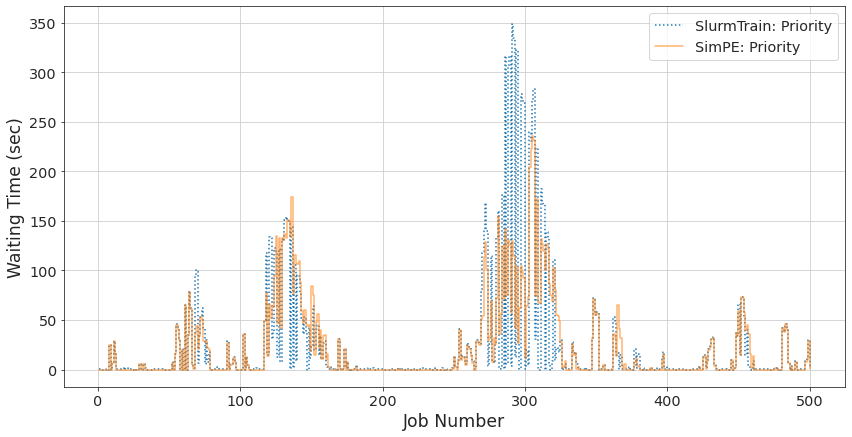

In [213]:
# n = 200

fig, ax = plt.subplots(figsize=[14,7])
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# runs=range(0,10)
save_this_plot = True

run = 10
j = run-1
st_acct = dic_st_prio_sacct[j].loc[:, ['JobName', 'wait_time']].copy()
st_acct['job_name'] = st_acct['JobName'].astype(int)
st_acct['RunType'] = 'slurmtrain'
st_acct['SchedType'] = 'Priority'

sala_jobs = dic_sala_prio_dfjobs[j].loc[:, ['job_name', 'wait_time','job_prio']].copy()
sala_jobs['job_name'] = sala_jobs['job_name'].astype(int)
sala_jobs['RunType'] = 'salabim'
sala_jobs['SchedType'] = 'Priority'

compare_wait = pd.merge(left=sala_jobs, 
                        right=st_acct, 
                        how="inner",
                        on="job_name",
                        suffixes = ("_sala", "_st")
                        )

compare_wait['Job Number'] = compare_wait.job_name - 1000 + 1


# Plot
ax.step(compare_wait['Job Number'], 
    compare_wait.wait_time_st,
    linestyle='dotted',
    where='post',
    label = f"SlurmTrain: Priority",
    alpha=1)

# Plot 
ax.step(compare_wait['Job Number'], 
    compare_wait.wait_time_sala,
    linestyle='solid',
    where='post',
    label = f"SimPE: Priority",
    alpha=.6)
    
ax.legend()
ax.set_xlabel('Job Number')
# ax.set_ylabel(r'PE Available / Max PE')
ax.set_ylabel('Waiting Time (sec)')

myrun_models = f"{myrun_type}_wait_step_plot_run{run}"
pltpath = f'{save_image_path}/{myrun_shortname}_{myrun_models}.png'

if save_this_plot:
    plt.savefig(pltpath, facecolor='w', transparent=False, dpi=300)

plt.show()

# Investigate the static priority:  high priority decrease in waiting time

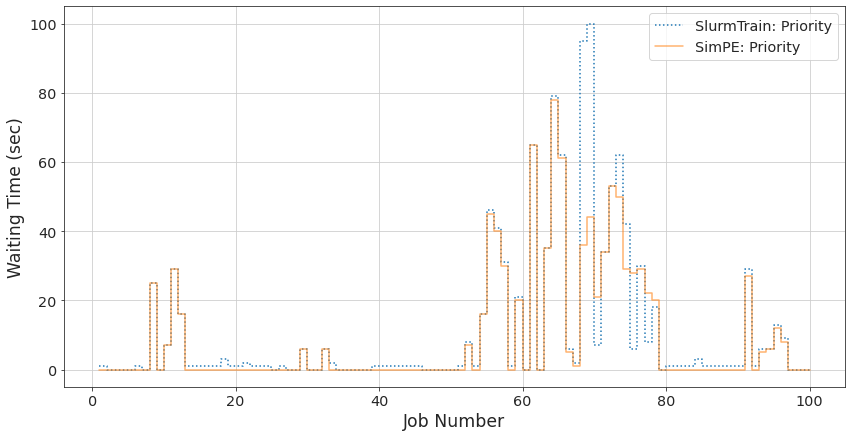

In [195]:
# n = 200

fig, ax = plt.subplots(figsize=[14,7])
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# runs=range(0,10)
save_this_plot = True

run = 10
j = run-1
st_acct = dic_st_prio_sacct[j].loc[:, ['JobName', 'wait_time']].copy()
st_acct['job_name'] = st_acct['JobName'].astype(int)
st_acct['RunType'] = 'slurmtrain'
st_acct['SchedType'] = 'Priority'

sala_jobs = dic_sala_prio_dfjobs[j].loc[:, ['job_name', 'wait_time','job_prio']].copy()
sala_jobs['job_name'] = sala_jobs['job_name'].astype(int)
sala_jobs['RunType'] = 'salabim'
sala_jobs['SchedType'] = 'Priority'

compare_wait = pd.merge(left=sala_jobs, 
                        right=st_acct, 
                        how="inner",
                        on="job_name",
                        suffixes = ("_sala", "_st")
                        )

compare_wait['Job Number'] = compare_wait.job_name - 1000 + 1

first_n = 100

# Plot
ax.step(compare_wait['Job Number'].head(first_n), 
    compare_wait.wait_time_st.head(first_n),
    linestyle='dotted',
    where='post',
    label = f"SlurmTrain: Priority",
    alpha=1)

# Plot 
ax.step(compare_wait['Job Number'].head(first_n), 
    compare_wait.wait_time_sala.head(first_n),
    linestyle='solid',
    where='post',
    label = f"SimPE: Priority",
    alpha=.6)
    
ax.legend()
ax.set_xlabel('Job Number')
# ax.set_ylabel(r'PE Available / Max PE')
ax.set_ylabel('Waiting Time (sec)')

myrun_models = f"{myrun_type}_wait_step_plot_run{run}"
pltpath = f'{save_image_path}/{myrun_shortname}_{myrun_models}.png'

# if save_this_plot:
#     plt.savefig(pltpath, facecolor='w', transparent=False, dpi=300)

plt.show()

In [225]:
dic_st_prio_sacct[10-1].head(70).tail(1)

,Account,AdminComment,AllocCPUS,AllocNodes,AllocTRES,AssocID,AveCPU,AveCPUFreq,AveDiskRead,AveDiskWrite,...,submit_date,eligible_date,start_date,end_date,wait_time,elapsed_time,time_limit,pet,batch_name,batch_value
69,crucial,,1,1,"billing=1,cpu=1,mem=7424M,node=1",66,,,,,...,2023-07-27 06:00:08,2023-07-27 06:00:08,2023-07-27 06:00:15,2023-07-27 06:02:18,7.0,123.0,180.0,123.0,03_Inter_13.0,13


In [277]:
dic_sala_prio_dfjobs[10-1].head(74).tail(5)

,job_number,job_name,job_submit,batch_name,batch_value,job_start,job_end,job_pe_req,pe_avail,job_prio,slurm_comment,wait_time,run_time,backfill
69,69,1069,2020-01-01 12:18:14,03_Inter_13.0,13,2020-01-01 12:18:35,2020-01-01 12:20:38,1,0.0,10,,21.0,123.0,0
70,70,1070,2020-01-01 12:18:18,03_Inter_13.0,13,2020-01-01 12:18:52,2020-01-01 12:19:17,3,0.0,10,,34.0,25.0,0
71,71,1071,2020-01-01 12:18:24,03_Inter_13.0,13,2020-01-01 12:19:17,2020-01-01 12:19:48,3,0.0,10,,53.0,31.0,0
72,72,1072,2020-01-01 12:18:27,03_Inter_13.0,13,2020-01-01 12:19:17,2020-01-01 12:19:41,1,0.0,1,,50.0,24.0,0
73,73,1073,2020-01-01 12:18:49,03_Inter_13.0,13,2020-01-01 12:19:18,2020-01-01 12:19:43,1,1.0,1,,29.0,25.0,0


In [263]:
print_prio_pet.comment[1:].astype(int)

1       20680
2       20680
3       20681
4       20681
5       20682
        ...  
996     21170
997     21178
998     21177
999     21179
1000    21178
Name: comment, Length: 1000, dtype: int64

In [259]:
# print_prio_pet.comment.astype(int)-start_num

In [281]:
print_prio_pet = dic_st_prio_petime[10-1].copy()
print_prio_pet = print_prio_pet.iloc[1:] # drop first line

# print_prio_pet['comment'] = print_prio_pet['comment'].astype(int) 
# print_prio_pet['comment'] = print_prio_pet.comment -  print_prio_pet.comment[1] + 1

# print_prio_pet.head(2)
# start_num = int(print_prio_pet.comment[0])

# print_prio_pet['job_num'] = print_prio_pet.comment.

# display(start_num)
# print_prio_pet

# print_prio_pet

print_prio_pet.head(140).tail(25)

,event_time,event_id,event_type,comment,pe_delta,pe_avail,pe_avail_norm
116,2020-01-01 12:16:07,9,end,20735,3.0,4.0,0.500
117,2020-01-01 12:16:07,10,start,20738,-3.0,1.0,0.125
118,2020-01-01 12:16:10,10,start,20741,-1.0,0.0,0.000
119,2020-01-01 12:16:46,9,end,20736,3.0,3.0,0.375
120,2020-01-01 12:16:46,10,start,20742,-1.0,2.0,0.250
121,2020-01-01 12:17:01,9,end,20742,1.0,3.0,0.375
122,2020-01-01 12:17:01,10,start,20740,-3.0,0.0,0.000
123,2020-01-01 12:17:15,9,end,20737,1.0,1.0,0.125
124,2020-01-01 12:17:17,9,end,20738,3.0,4.0,0.500
125,2020-01-01 12:17:17,10,start,20745,-3.0,1.0,0.125


In [279]:
dic_sala_prio_petime[10-1].head(160).tail(35)

,event_time,event_id,event_type,comment,pe_delta,pe_avail,pe_avail_norm
125,2020-01-01 12:17:15,10,start,1065.0,-3.0,1.0,0.125
126,2020-01-01 12:17:15,10,start,1066.0,-1.0,0.0,0.000
127,2020-01-01 12:17:19,9,end,1061.0,1.0,1.0,0.125
128,2020-01-01 12:17:47,9,end,1065.0,3.0,4.0,0.500
129,2020-01-01 12:17:47,10,start,1063.0,-3.0,1.0,0.125
130,2020-01-01 12:17:47,10,start,1064.0,-1.0,0.0,0.000
131,2020-01-01 12:18:14,9,end,1064.0,1.0,1.0,0.125
132,2020-01-01 12:18:14,10,start,1067.0,-1.0,0.0,0.000
133,2020-01-01 12:18:27,9,end,1066.0,1.0,1.0,0.125
134,2020-01-01 12:18:27,10,start,1068.0,-1.0,0.0,0.000


In [196]:
pd.options.display.max_rows = 100
compare_wait.head(70).sort_values('job_name').tail(10)

,job_name,wait_time_sala,job_prio,RunType_sala,SchedType_sala,JobName,wait_time_st,RunType_st,SchedType_st,Job Number
60,1060,65.0,1,salabim,Priority,1060,65.0,slurmtrain,Priority,61
61,1061,0.0,10,salabim,Priority,1061,0.0,slurmtrain,Priority,62
62,1062,35.0,10,salabim,Priority,1062,35.0,slurmtrain,Priority,63
63,1063,78.0,1,salabim,Priority,1063,79.0,slurmtrain,Priority,64
64,1064,61.0,1,salabim,Priority,1064,62.0,slurmtrain,Priority,65
65,1065,5.0,10,salabim,Priority,1065,6.0,slurmtrain,Priority,66
66,1066,1.0,10,salabim,Priority,1066,2.0,slurmtrain,Priority,67
67,1067,36.0,1,salabim,Priority,1067,95.0,slurmtrain,Priority,68
68,1068,44.0,1,salabim,Priority,1068,100.0,slurmtrain,Priority,69
69,1069,21.0,10,salabim,Priority,1069,7.0,slurmtrain,Priority,70


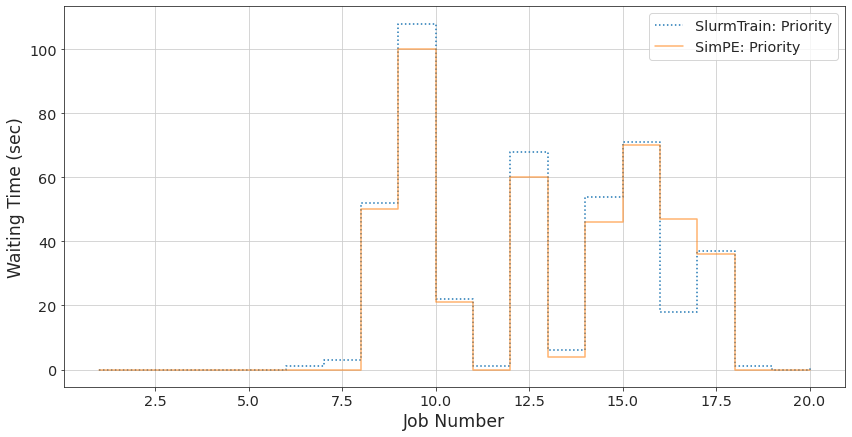

In [204]:
# n = 200

fig, ax = plt.subplots(figsize=[14,7])
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# runs=range(0,10)
save_this_plot = True

run = 9
j = run-1
st_acct = dic_st_prio_sacct[j].loc[:, ['JobName', 'wait_time']].copy()
st_acct['job_name'] = st_acct['JobName'].astype(int)
st_acct['RunType'] = 'slurmtrain'
st_acct['SchedType'] = 'Priority'

sala_jobs = dic_sala_prio_dfjobs[j].loc[:, ['job_name', 'wait_time','job_prio']].copy()
sala_jobs['job_name'] = sala_jobs['job_name'].astype(int)
sala_jobs['RunType'] = 'salabim'
sala_jobs['SchedType'] = 'Priority'

compare_wait = pd.merge(left=sala_jobs, 
                        right=st_acct, 
                        how="inner",
                        on="job_name",
                        suffixes = ("_sala", "_st")
                        )

compare_wait['Job Number'] = compare_wait.job_name - 1000 + 1

first_n = 20

# Plot
ax.step(compare_wait['Job Number'].head(first_n), 
    compare_wait.wait_time_st.head(first_n),
    linestyle='dotted',
    where='post',
    label = f"SlurmTrain: Priority",
    alpha=1)

# Plot 
ax.step(compare_wait['Job Number'].head(first_n), 
    compare_wait.wait_time_sala.head(first_n),
    linestyle='solid',
    where='post',
    label = f"SimPE: Priority",
    alpha=.6)
    
ax.legend()
ax.set_xlabel('Job Number')
# ax.set_ylabel(r'PE Available / Max PE')
ax.set_ylabel('Waiting Time (sec)')

myrun_models = f"{myrun_type}_wait_step_plot_run{run}"
pltpath = f'{save_image_path}/{myrun_shortname}_{myrun_models}.png'

# if save_this_plot:
#     plt.savefig(pltpath, facecolor='w', transparent=False, dpi=300)

plt.show()

In [203]:
pd.options.display.max_rows = 100
compare_wait.head(20).sort_values('job_name') # .tail(10)
# compare_wait[compare_wait.job_prio==10].sort_values('job_name').head(20)

,job_name,wait_time_sala,job_prio,RunType_sala,SchedType_sala,JobName,wait_time_st,RunType_st,SchedType_st,Job Number
0,1000,0.0,10,salabim,Priority,1000,0.0,slurmtrain,Priority,1
1,1001,0.0,1,salabim,Priority,1001,0.0,slurmtrain,Priority,2
2,1002,0.0,10,salabim,Priority,1002,0.0,slurmtrain,Priority,3
3,1003,0.0,1,salabim,Priority,1003,0.0,slurmtrain,Priority,4
4,1004,0.0,10,salabim,Priority,1004,0.0,slurmtrain,Priority,5
5,1005,0.0,10,salabim,Priority,1005,1.0,slurmtrain,Priority,6
6,1006,0.0,10,salabim,Priority,1006,3.0,slurmtrain,Priority,7
7,1007,50.0,1,salabim,Priority,1007,52.0,slurmtrain,Priority,8
8,1008,100.0,1,salabim,Priority,1008,108.0,slurmtrain,Priority,9
9,1009,21.0,10,salabim,Priority,1009,22.0,slurmtrain,Priority,10


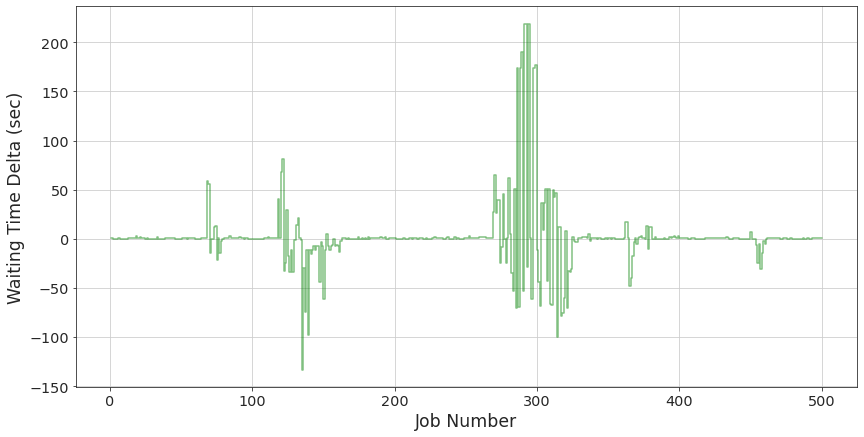

In [164]:
fig, ax = plt.subplots(figsize=[14,7])
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

runs=range(8,9)

for j in runs:
    st_acct = dic_st_prio_sacct[j].loc[:, ['JobName', 'wait_time']].copy()
    st_acct['job_name'] = st_acct['JobName'].astype(int)
    st_acct['RunType'] = 'slurmtrain'
    st_acct['SchedType'] = 'Priority'

    sala_jobs = dic_sala_prio_dfjobs[j].loc[:, ['job_name', 'wait_time']].copy()
    sala_jobs['job_name'] = sala_jobs['job_name'].astype(int)
    sala_jobs['RunType'] = 'salabim'
    sala_jobs['SchedType'] = 'Priority'

    compare_wait = pd.merge(left=sala_jobs, 
                            right=st_acct, 
                            how="inner",
                            on="job_name",
                            suffixes = ("_sala", "_st")
                            )
    
    compare_wait['Job Number'] = compare_wait.job_name - 1000 + 1

    
    # Plot
    ax.step(compare_wait['Job Number'], 
        compare_wait.wait_time_st - compare_wait.wait_time_sala,
        where='post',
        label = f"Jitter: SlurmTrain - SimPE",
        c='g',
        alpha=.5,
        )
    
# ax.legend()
ax.set_xlabel('Job Number')
# ax.set_ylabel(r'PE Available / Max PE')
ax.set_ylabel('Waiting Time Delta (sec)')

myrun_models = f"{myrun_type}_wait_jitter_plot"
pltpath = f'{save_image_path}/{myrun_shortname}_{myrun_models}.png'

plt.savefig(pltpath, facecolor='w', transparent=False, dpi=300)

plt.show()

### Jitter Wait Delta: histogram

In [97]:
runs=range(0,10)

list_compare_wait = []

for j in runs:
    st_acct = dic_st_prio_sacct[j].loc[:, ['JobName', 'pe_req', 'Account', 'wait_time']].copy()
    st_acct = st_acct.rename(columns={'pe_req':'job_pe_req'})
    st_acct['priority'] = np.select([st_acct.Account == "training", st_acct.Account == "crucial"], ["Low", "High"])
    st_acct['job_name'] = st_acct['JobName'].astype(int)
    st_acct['RunType'] = 'slurmtrain'
    st_acct['SchedType'] = 'Priority'

    sala_jobs = dic_sala_prio_dfjobs[j].loc[:, ['job_name', 'job_pe_req', "job_prio", 'wait_time']].copy()
    sala_jobs['priority'] = np.select([sala_jobs.job_prio == 1, sala_jobs.job_prio==10], ["Low", "High"])
    sala_jobs['job_name'] = sala_jobs['job_name'].astype(int)
    sala_jobs['RunType'] = 'salabim'
    sala_jobs['SchedType'] = 'Priority'

    compare_wait = pd.merge(left=sala_jobs, 
                            right=st_acct, 
                            how="inner",
                            on=["job_name", "job_pe_req", "priority"],
                            suffixes = ("_sala", "_st")
                            )
    
    compare_wait['Job Number'] = compare_wait.job_name - 1000 + 1
    compare_wait['run_num'] = j+1
    
    compare_wait['delta_wait'] = compare_wait.wait_time_st - compare_wait.wait_time_sala
  
    list_compare_wait.append(compare_wait)

#     # Plot
#     ax.step(compare_wait['Job Number'], 
#         compare_wait.wait_time_st - compare_wait.wait_time_sala,
#         where='post',
#         label = f"Jitter: SlurmTrain - SimPE",
#         c='g',
#         alpha=.5,
#         )

compare_wait_all = (pd.concat(list_compare_wait)
                    .reset_index(drop=True)
                    .loc[:, ["run_num", "SchedType_st", "Job Number","job_name", 
                             "job_pe_req","priority",
                             "wait_time_st", "wait_time_sala", "delta_wait"]]
                   )

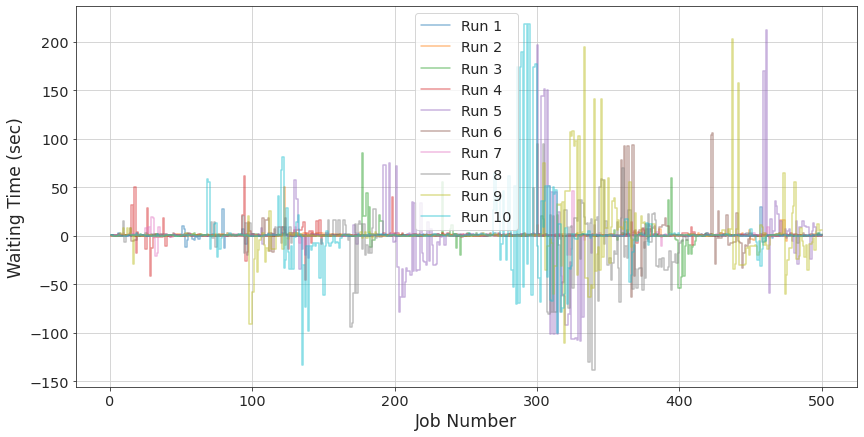

In [98]:
fig, ax = plt.subplots(figsize=[14,7])
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

runs=range(0,10)

compare_wait_all=compare_wait_all.set_index('run_num')

for run in compare_wait_all.index.unique():
    # Plot
    
    ax.step(compare_wait_all.loc[run]['Job Number'], 
        compare_wait_all.loc[run].delta_wait,
        where='post',
        label = f"Run {run}",
#         c='g',
        alpha=.5,
        )

compare_wait_all=compare_wait_all.reset_index()
    
ax.legend()
ax.set_xlabel('Job Number')
# ax.set_ylabel(r'PE Available / Max PE')
ax.set_ylabel('Waiting Time (sec)')

myrun_models = f"{myrun_type}_wait_jitter_plot_colour"
pltpath = f'{save_image_path}/debug/{myrun_shortname}_{myrun_models}.png'

# plt.savefig(pltpath, facecolor='w', transparent=False)

plt.show()

### Tables

#### Wait Table All

In [150]:
compare_wait_all.head()

,run_num,SchedType_st,Job Number,job_name,job_pe_req,priority,wait_time_st,wait_time_sala,delta_wait
0,1,Priority,1,1000,3,Low,1.0,0.0,1.0
1,1,Priority,2,1001,3,High,1.0,0.0,1.0
2,1,Priority,3,1002,1,Low,1.0,0.0,1.0
3,1,Priority,4,1003,3,High,1.0,0.0,1.0
4,1,Priority,5,1004,1,High,1.0,0.0,1.0


In [209]:
wait_table_all = (compare_wait_all
#  .query("run_num == 1")
 .loc[:, ['run_num', 'job_name', 'wait_time_st', 'wait_time_sala', 'delta_wait']]
 .groupby('run_num')
 .agg({'job_name' : ['count'],
       'wait_time_sala' : ['mean'],
       'wait_time_st' : ['mean']})
 .reset_index(drop=False)
)

wait_table_all["ratio"] = wait_table_all.wait_time_sala / wait_table_all.wait_time_st

wait_table_all["delta"] = wait_table_all.wait_time_st - wait_table_all.wait_time_sala

# wait_table_all.columns = wait_table_all.columns.droplevel(1)

# wait_table_all = wait_table_all.rename(columns={'run_num':'Run Number'})

# wait_table_all.set_index('Run Number', inplace=True)

# mycolumns = [('', 'Run Number'),
#              ('', 'Job Count'), 
#              ('Waiting Time', 'SlurmTrain'),
#              ('Waiting Time', 'SimPE'),
#              ('Waiting Time', 'Delta')]

# wait_table_all.columns = pd.MultiIndex.from_tuples(mycolumns)

wait_table_all

,run_num,job_name,wait_time_sala,wait_time_st,ratio,delta
,,count,mean,mean,,
0,1,500,3.670,4.428,0.828817,0.758
1,2,500,10.174,11.118,0.915093,0.944
2,3,500,6.512,7.364,0.884302,0.852
3,4,500,10.282,11.436,0.899091,1.154
4,5,500,22.208,21.854,1.016198,-0.354
5,6,500,8.082,9.866,0.819177,1.784
6,7,500,6.464,6.974,0.926871,0.510
7,8,500,31.506,29.058,1.084245,-2.448
8,9,500,22.210,23.954,0.927194,1.744


In [100]:
table_name = f"{myrun_type}_wait_table_all.tex"
table_path = Path(f'{save_image_path}/tables/{table_name}')

print(f"LATEX OUTPUT: {table_path}")
print(f"LATEX INCLUDE: {table_name}")
# print(f"LATEX INCLUDE: \input{{{str(table_path.relative_to('images'))}}}")
print("")

latex_table = (wait_table_all
    .loc[:, ["run_num", "wait_time_sala", "wait_time_st", "ratio"
             #, "delta"
            ]]
    .droplevel(1, axis=1)
    .to_latex(index = False,
            column_format = 'ccccc',
            header=["Run Number", 
                    r"$\overline{W}^{(pri)}_{PE}$",
                    r"$\overline{W}^{(pri)}_{ST}$",
                    r"$\overline{W}^{(pri)}_{PE} / \overline{W}^{(pri)}_{ST}$"
                    # ,r"$\overline{W}_{ST} - \overline{W}_{PE}$"
                   ],
            float_format="%.2f",
            escape = False)
)

# # Modifications to the latex table code:

# latex_list = latex_table.splitlines()

# new_header_list = [
# r"\begin{tabular}{lrrrr}",
# r"\toprule",
# r"& & \multicolumn{3}{c}{Average Waiting Time (sec)} \\ \cline{3-5}" ,
# r"Run Number & Count & SlurmTrain & SimPE & Delta \\",
# r"\midrule"
# ]

# latex_new_list = new_header_list + latex_list[2:]

# # # latex_list.insert(3, r'\cmidrule(lr){3-5} \\')

# # # for i,line in enumerate(latex_list): 
# # #     if line.find(r"\begin{table}") >= 0: 
# # #         latex_list[i] = r"\begin{table}[!ht]"

# latex_new_table = "\n".join(latex_new_list)
    
# print(latex_new_table)

print(latex_table)

# # Write Output
with open(table_path, 'w') as f:
    f.write(latex_table)

LATEX OUTPUT: images/results/tables/priorun_wait_table_all.tex
LATEX INCLUDE: priorun_wait_table_all.tex

\begin{tabular}{ccccc}
\toprule
Run Number & $\overline{W}^{(pri)}_{PE}$ & $\overline{W}^{(pri)}_{ST}$ & $\overline{W}^{(pri)}_{PE} / \overline{W}^{(pri)}_{ST}$ \\
\midrule
         1 &                        3.67 &                        4.43 &                                               0.83 \\
         2 &                       10.17 &                       11.12 &                                               0.92 \\
         3 &                        6.51 &                        7.36 &                                               0.88 \\
         4 &                       10.28 &                       11.44 &                                               0.90 \\
         5 &                       22.21 &                       21.85 &                                               1.02 \\
         6 &                        8.08 &                        9.87 &              

#### Wait Table Metrics

In [101]:
# Waiting time all jobs - metric table

wait_table_all_metrics = wait_table_all.copy()

wait_table_all_metrics.columns = wait_table_all_metrics.columns.droplevel(1)

# metrics = ['min', 'max',  'std', 'mean']
# metric_names = ['min', 'max', '$s_{dev}$', 'average']

wait_table_all_metrics = (wait_table_all_metrics
                          .drop(columns=['run_num', 'job_name', 'delta'])
                          .agg(metrics)
                          .reset_index()
                          .rename(columns={'index':'metric'})
                          .assign(metric_name = metric_names)
                         )

wait_table_all_metrics

# wait_table_all.columns

,metric,wait_time_sala,wait_time_st,ratio,metric_name
0,min,3.670000,4.428000,0.819177,min
1,max,31.506000,29.058000,1.084245,max
2,std,9.432661,8.865157,0.079233,$s_{dev}$
3,mean,14.394200,15.074600,0.922567,average


In [102]:
table_name = f"{myrun_type}_wait_table_all_metrics.tex"
table_path = Path(f'{save_image_path}/tables/{table_name}')

print(f"LATEX OUTPUT: {table_path}")
print(f"LATEX INCLUDE: {table_name}")
# print(f"LATEX INCLUDE: \input{{{str(table_path.relative_to('images'))}}}")
print("")

latex_table = (wait_table_all_metrics
    .loc[:, ["metric_name", "wait_time_sala", "wait_time_st", "ratio"
            # , "delta"
            ]]
    .to_latex(index = False,
            column_format = 'lcccc',
            header=["Metric", 
                    r"$\overline{W}^{(pri)}_{PE}$",
                    r"$\overline{W}^{(pri)}_{ST}$",
                    r"$\overline{W}^{(pri)}_{PE} / \overline{W}^{(pri)}_{ST}$" #,
              #      r"$\overline{W}_{ST} - \overline{W}_{PE}$"
                   ],
            float_format="%.2f",
            escape = False)
)

# # Modifications to the latex table code:

# latex_list = latex_table.splitlines()

# new_header_list = [
# r"\begin{tabular}{lrrrr}",
# r"\toprule",
# r"& & \multicolumn{3}{c}{Average Waiting Time (sec)} \\ \cline{3-5}" ,
# r"Run Number & Count & SlurmTrain & SimPE & Delta \\",
# r"\midrule"
# ]

# latex_new_list = new_header_list + latex_list[2:]

# # # latex_list.insert(3, r'\cmidrule(lr){3-5} \\')

# # # for i,line in enumerate(latex_list): 
# # #     if line.find(r"\begin{table}") >= 0: 
# # #         latex_list[i] = r"\begin{table}[!ht]"

# latex_new_table = "\n".join(latex_new_list)
    
# print(latex_new_table)

print(latex_table)

# # Write Output
with open(table_path, 'w') as f:
    f.write(latex_table)

LATEX OUTPUT: images/results/tables/priorun_wait_table_all_metrics.tex
LATEX INCLUDE: priorun_wait_table_all_metrics.tex

\begin{tabular}{lcccc}
\toprule
    Metric & $\overline{W}^{(pri)}_{PE}$ & $\overline{W}^{(pri)}_{ST}$ & $\overline{W}^{(pri)}_{PE} / \overline{W}^{(pri)}_{ST}$ \\
\midrule
       min &                        3.67 &                        4.43 &                                               0.82 \\
       max &                       31.51 &                       29.06 &                                               1.08 \\
 $s_{dev}$ &                        9.43 &                        8.87 &                                               0.08 \\
   average &                       14.39 &                       15.07 &                                               0.92 \\
\bottomrule
\end{tabular}



#### Wait Table per Job Type

In [103]:
# Waiting Time per job 

wait_table_jobtype_all = (compare_wait_all
#  .query("run_num == 1")
 .loc[:, ['run_num', 'job_pe_req', "priority", 'job_name', 'wait_time_st', 'wait_time_sala', 'delta_wait']]
 .assign(str_job_pe_req = lambda x: x.job_pe_req.astype(str))
 .groupby(['run_num','str_job_pe_req', "priority"])
 .agg({'job_name' : ['count'],
       'wait_time_sala' : ['mean'],
       'wait_time_st' : ['mean']})
 .reset_index(drop=False)
)

wait_table_jobtype_all["ratio"] = wait_table_jobtype_all.wait_time_sala / wait_table_jobtype_all.wait_time_st

wait_table_jobtype_all["delta"] = wait_table_jobtype_all.wait_time_st - wait_table_jobtype_all.wait_time_sala

wait_table_jobtype_all.columns = wait_table_jobtype_all.columns.droplevel(1)
wait_table_jobtype_all.rename(columns={'job_name':'job_count',
                                       'str_job_pe_req' : 'job_pe_req'}, inplace=True)

wait_table_jobtype_all["job_type"] = wait_table_jobtype_all.job_pe_req + " PE - " + wait_table_jobtype_all.priority + " Priority"

wait_table_jobtype_all.head()

,run_num,job_pe_req,priority,job_count,wait_time_sala,wait_time_st,ratio,delta,job_type
0,1,1,High,142,1.345070,1.880282,0.715356,0.535211,1 PE - High Priority
1,1,1,Low,115,2.921739,3.713043,0.786885,0.791304,1 PE - Low Priority
2,1,3,High,115,5.800000,6.200000,0.935484,0.400000,3 PE - High Priority
3,1,3,Low,128,5.007812,6.304688,0.794300,1.296875,3 PE - Low Priority
4,2,1,High,114,3.657895,4.210526,0.868750,0.552632,1 PE - High Priority


In [104]:
batch_count = wait_table_jobtype_all.run_num.max()

wait_table_jobtype_table = (wait_table_jobtype_all
                            .groupby(["priority", "job_pe_req", "job_type"])
                            .agg({'job_count' : ['sum'],
                                  'wait_time_sala' :['mean'],
                                  'wait_time_st' :['mean']})
                            .sort_index(ascending=[False, True])
                            .droplevel(1,axis=1)
                            .reset_index(drop=False)
                            .assign(ratio = lambda x: x.wait_time_sala / x.wait_time_st)
                            .assign(delta = lambda x: x.wait_time_st - x.wait_time_sala)
                            .assign(jobs_per_batch = lambda x: x.job_count / batch_count)
                            .drop(columns='priority')
)

wait_table_jobtype_table

,job_pe_req,job_type,job_count,wait_time_sala,wait_time_st,ratio,delta,jobs_per_batch
0,1,1 PE - Low Priority,1239,15.131656,19.462993,0.777458,4.331337,123.9
1,3,3 PE - Low Priority,1240,22.410561,26.958340,0.831303,4.547779,124.0
2,1,1 PE - High Priority,1222,6.703491,3.951941,1.696253,-2.751550,122.2
3,3,3 PE - High Priority,1299,12.991346,9.720658,1.336468,-3.270688,129.9


In [105]:
table_name = f"{myrun_type}_wait_table_jobtypes.tex"
table_path = Path(f'{save_image_path}/tables/{table_name}')

print(f"LATEX OUTPUT: {table_path}")
print(f"LATEX INCLUDE: {table_name}")
print("")

latex_table = (wait_table_jobtype_table
               .loc[:, ['job_type', 'jobs_per_batch', 'wait_time_sala', 'wait_time_st', 'ratio']]
               .to_latex(
    index=False,
    column_format='cccccc',
    header=["Job Type", 
            "Average Jobs Per Batch",
            r"$\mu_{\overline{W}^{(pri)}_{PE}}$",
            r"$\mu_{\overline{W}^{(pri)}_{ST}}$",
            r"$\mu_{\overline{W}^{(pri)}_{PE}} / \mu_{\overline{W}^{(pri)}_{ST}}$" #,
            #r"$\mu_{\overline{W}_{ST}} - \mu_{\overline{W}_{PE}}$"
           ],
    float_format="%.2f",
    escape = False) 
)
    
print(latex_table)
    
# # # Write Output
with open(table_path, 'w') as f:
    f.write(latex_table)

LATEX OUTPUT: images/results/tables/priorun_wait_table_jobtypes.tex
LATEX INCLUDE: priorun_wait_table_jobtypes.tex

\begin{tabular}{cccccc}
\toprule
             Job Type & Average Jobs Per Batch & $\mu_{\overline{W}^{(pri)}_{PE}}$ & $\mu_{\overline{W}^{(pri)}_{ST}}$ & $\mu_{\overline{W}^{(pri)}_{PE}} / \mu_{\overline{W}^{(pri)}_{ST}}$ \\
\midrule
  1 PE - Low Priority &                 123.90 &                             15.13 &                             19.46 &                                               0.78 \\
  3 PE - Low Priority &                 124.00 &                             22.41 &                             26.96 &                                               0.83 \\
 1 PE - High Priority &                 122.20 &                              6.70 &                              3.95 &                                               1.70 \\
 3 PE - High Priority &                 129.90 &                             12.99 &                              9.72 &     

#### Wait Table Per Run Number and Job Type (for debugging)

In [156]:
batch_count = wait_table_jobtype_all.run_num.max()

wait_table_run_jobtype_table = (wait_table_jobtype_all
                            .groupby(["run_num", "priority", "job_pe_req", "job_type"])
                            .agg({'job_count' : ['sum'],
                                  'wait_time_sala' :['mean'],
                                  'wait_time_st' :['mean']})
                            .sort_index(ascending=[True, False, True])
                            .droplevel(1,axis=1)
                            .reset_index(drop=False)
                            .assign(ratio = lambda x: x.wait_time_sala / x.wait_time_st)
                            .assign(delta = lambda x: x.wait_time_st - x.wait_time_sala)
                            .assign(jobs_per_batch = lambda x: x.job_count / batch_count)
                            .drop(columns='priority')
)

pd.set_option('precision', 2)

display(wait_table_run_jobtype_table)

pd.reset_option('precision')

,run_num,job_pe_req,job_type,job_count,wait_time_sala,wait_time_st,ratio,delta,jobs_per_batch
0,1,1,1 PE - Low Priority,115,2.92,3.71,0.79,0.79,11.5
1,1,3,3 PE - Low Priority,128,5.01,6.30,0.79,1.30,12.8
2,1,1,1 PE - High Priority,142,1.35,1.88,0.72,0.54,14.2
3,1,3,3 PE - High Priority,115,5.80,6.20,0.94,0.40,11.5
4,2,1,1 PE - Low Priority,141,8.60,10.03,0.86,1.43,14.1
5,2,3,3 PE - Low Priority,120,15.78,16.81,0.94,1.03,12.0
6,2,1,1 PE - High Priority,114,3.66,4.21,0.87,0.55,11.4
7,2,3,3 PE - High Priority,125,12.51,13.18,0.95,0.67,12.5
8,3,1,1 PE - Low Priority,126,7.11,9.33,0.76,2.21,12.6
9,3,3,3 PE - Low Priority,116,7.85,9.21,0.85,1.35,11.6


#### Waiting time Job Type Metric table (for debugging)

In [161]:
# Waiting time all jobs - metric table

wait_table_jobtype_metrics = wait_table_jobtype_all.copy()

metrics_jt = ['min', 'max',  'mean']

wait_table_jobtype_metrics = (wait_table_jobtype_metrics
                          .drop(columns=['run_num', 'delta','job_count'])
                          .groupby(['priority', 'job_pe_req', 'job_type'])
                          .agg(metrics_jt)
                          .reset_index()
                          .rename(columns={'index':'metric'})
                          .sort_values(['priority', 'job_pe_req'], ascending=[False, True])
                          .drop(columns=['priority', 'job_pe_req'], level=0)
                          .reset_index(drop=True)
                         )

pd.set_option('precision', 2)

display(wait_table_jobtype_metrics)

pd.reset_option('precision')

job_type wait_time_sala               wait_time_st         \
                                   min    max   mean          min    max   
0   1 PE - Low Priority           2.92  33.81  15.13         3.71  37.80   
1   3 PE - Low Priority           5.01  54.05  22.41         6.30  57.74   
2  1 PE - High Priority           1.35  14.81   6.70         1.88   5.43   
3  3 PE - High Priority           5.80  20.59  12.99         6.20  14.15   

         ratio              
    mean   min   max  mean  
0  19.46  0.62  0.89  0.78  
1  26.96  0.75  0.94  0.84  
2   3.95  0.72  2.92  1.59  
3   9.72  0.94  1.97  1.30

In [162]:
# Waiting time all jobs - metric table ('median ony')

wait_table_jobtype_metrics = wait_table_jobtype_all.copy()

metrics_jt = ['median']

wait_table_jobtype_metrics = (wait_table_jobtype_metrics
                          .drop(columns=['run_num', 'delta','job_count'])
                          .groupby(['priority', 'job_pe_req', 'job_type'])
                          .agg(metrics_jt)
                          .reset_index()
                          .rename(columns={'index':'metric'})
                          .sort_values(['priority', 'job_pe_req'], ascending=[False, True])
                          .drop(columns=['priority', 'job_pe_req'], level=0)
                          .reset_index(drop=True)
                         )

pd.set_option('precision', 2)

display(wait_table_jobtype_metrics)

pd.reset_option('precision')

,job_type,wait_time_sala,wait_time_st,ratio
,,median,median,median
0,1 PE - Low Priority,9.99,12.43,0.79
1,3 PE - Low Priority,15.72,18.06,0.82
2,1 PE - High Priority,4.45,4.21,1.11
3,3 PE - High Priority,11.23,9.68,1.11


In [159]:
table_name = f"{myrun_type}_wait_table_jobtype_all_metrics.tex"
table_path = Path(f'{save_image_path}/tables/{table_name}')

print(f"LATEX OUTPUT: {table_path}")
print(f"LATEX INCLUDE: {table_name}")
# print(f"LATEX INCLUDE: \input{{{str(table_path.relative_to('images'))}}}")
print("")

latex_table = (wait_table_all_metrics
    .loc[:, ["metric_name", "wait_time_sala", "wait_time_st", "ratio"
            # , "delta"
            ]]
    .to_latex(index = False,
            column_format = 'lcccc',
            header=["Metric", 
                    r"$\overline{W}^{(pri)}_{PE}$",
                    r"$\overline{W}^{(pri)}_{ST}$",
                    r"$\overline{W}^{(pri)}_{PE} / \overline{W}^{(pri)}_{ST}$" #,
              #      r"$\overline{W}_{ST} - \overline{W}_{PE}$"
                   ],
            float_format="%.2f",
            escape = False)
)

# # Modifications to the latex table code:

# latex_list = latex_table.splitlines()

# new_header_list = [
# r"\begin{tabular}{lrrrr}",
# r"\toprule",
# r"& & \multicolumn{3}{c}{Average Waiting Time (sec)} \\ \cline{3-5}" ,
# r"Run Number & Count & SlurmTrain & SimPE & Delta \\",
# r"\midrule"
# ]

# latex_new_list = new_header_list + latex_list[2:]

# # # latex_list.insert(3, r'\cmidrule(lr){3-5} \\')

# # # for i,line in enumerate(latex_list): 
# # #     if line.find(r"\begin{table}") >= 0: 
# # #         latex_list[i] = r"\begin{table}[!ht]"

# latex_new_table = "\n".join(latex_new_list)
    
# print(latex_new_table)

print(latex_table)

# # Write Output
# with open(table_path, 'w') as f:
#     f.write(latex_table)

# NOT CURRENTLY USED

LATEX OUTPUT: images/results/tables/priorun_wait_table_jobtype_all_metrics.tex
LATEX INCLUDE: priorun_wait_table_jobtype_all_metrics.tex

\begin{tabular}{lcccc}
\toprule
    Metric & $\overline{W}^{(pri)}_{PE}$ & $\overline{W}^{(pri)}_{ST}$ & $\overline{W}^{(pri)}_{PE} / \overline{W}^{(pri)}_{ST}$ \\
\midrule
       min &                        3.67 &                        4.43 &                                               0.82 \\
       max &                       31.51 &                       29.06 &                                               1.08 \\
 $s_{dev}$ &                        9.43 &                        8.87 &                                               0.08 \\
   average &                       14.39 &                       15.07 &                                               0.92 \\
\bottomrule
\end{tabular}



### OLD Wait Tables (delta)

In [33]:
# wait_table_all = (compare_wait_all
# #  .query("run_num == 1")
#  .loc[:, ['run_num', 'job_name', 'wait_time_st', 'wait_time_sala', 'delta_wait']]
#  .groupby('run_num')
#  .agg({'job_name' : ['count'],
#        'wait_time_sala' : ['mean'],
#        'wait_time_st' : ['mean']})
#  .reset_index(drop=False)
# )

# wait_table_all["delta"] = wait_table_all.wait_time_st - wait_table_all.wait_time_sala

# # wait_table_all.columns = wait_table_all.columns.droplevel(1)

# # wait_table_all = wait_table_all.rename(columns={'run_num':'Run Number'})

# # wait_table_all.set_index('Run Number', inplace=True)

# # mycolumns = [('', 'Run Number'),
# #              ('', 'Job Count'), 
# #              ('Waiting Time', 'SlurmTrain'),
# #              ('Waiting Time', 'SimPE'),
# #              ('Waiting Time', 'Delta')]

# # wait_table_all.columns = pd.MultiIndex.from_tuples(mycolumns)

# wait_table_all

In [34]:
# table_name = f"{myrun_type}_wait_table_all.tex"
# table_path = Path(f'{save_image_path}/tables/{table_name}')

# print(f"LATEX OUTPUT: {table_path}")
# print(f"LATEX INCLUDE: {table_name}")
# # print(f"LATEX INCLUDE: \input{{{str(table_path.relative_to('images'))}}}")
# print("")

# latex_table = wait_table_all.to_latex(column_format='lrrrr',
# #                                       multirow=True,
#                                       header=False,
#                                       index=False
# #                                       multicolumn_format='c'
#                                       # caption="FIFO Results Table",
#                                       # label=table_name
#                                      )

# # Modifications to the latex table code:

# latex_list = latex_table.splitlines()

# new_header_list = [
# r"\begin{tabular}{lrrrr}",
# r"\toprule",
# r"& & \multicolumn{3}{c}{Waiting Time (sec)} \\ \cline{3-5}" ,
# r"Run Number & Count & SlurmTrain & SimPE & Delta \\",
# r"\midrule"
# ]

# latex_new_list = new_header_list + latex_list[2:]

# # # latex_list.insert(3, r'\cmidrule(lr){3-5} \\')

# # # for i,line in enumerate(latex_list): 
# # #     if line.find(r"\begin{table}") >= 0: 
# # #         latex_list[i] = r"\begin{table}[!ht]"

# latex_new_table = "\n".join(latex_new_list)
    
# print(latex_new_table)
    
# # # Write Output
# with open(table_path, 'w') as f:
#     f.write(latex_new_table)

In [35]:
# # Waiting Time per job 

# wait_table_jobtype_all = (compare_wait_all
# #  .query("run_num == 1")
#  .loc[:, ['run_num', 'job_pe_req', "priority", 'job_name', 'wait_time_st', 'wait_time_sala', 'delta_wait']]
#  .assign(str_job_pe_req = lambda x: x.job_pe_req.astype(str))
#  .groupby(['run_num','str_job_pe_req', "priority"])
#  .agg({'job_name' : ['count'],
#        'wait_time_st' : ['mean'],
#        'wait_time_sala' : ['mean']})
#  .reset_index(drop=False)
# )

# wait_table_jobtype_all["delta"] = wait_table_jobtype_all.wait_time_st - wait_table_jobtype_all.wait_time_sala

# wait_table_jobtype_all.columns = wait_table_jobtype_all.columns.droplevel(1)
# wait_table_jobtype_all.rename(columns={'job_name':'job_count',
#                                        'str_job_pe_req' : 'job_pe_req'}, inplace=True)

# wait_table_jobtype_all["job_type"] = wait_table_jobtype_all.job_pe_req + " PE - " + wait_table_jobtype_all.priority + " Priority"

# wait_table_jobtype_all.head()

In [36]:
# wait_table_jobtype_table0 = (wait_table_jobtype_all
#                             .groupby(["priority", "job_pe_req", "job_type"])
#                             .agg({'run_num' : ['nunique'],
#                                   'job_count' : ['sum'],
#                                   'wait_time_st' :['mean'],
#                                   'wait_time_sala' :['mean'],
#                                   'delta': ['mean', 'std']})
#                             .sort_index(ascending=[False, True, True])
#                            )

# wait_table_jobtype_table0.reset_index(inplace=True)
# wait_table_jobtype_table0.drop(columns=["priority", "job_pe_req"], inplace=True, level = 0)
# wait_table_jobtype_table0.set_index("job_type", inplace=True)

# wait_table_jobtype_table0

In [37]:
# # Combined

# wait_all_jobs_row = (wait_table_jobtype_all
#                      .assign(job_type = 'ALL')
#                      .groupby(['job_type'])
#                      .agg({'run_num' : ['nunique'],
#                            'job_count' : ['sum'],
#                            'wait_time_st' :['mean'],
#                            'wait_time_sala' :['mean'],
#                            'delta': ['mean', 'std']})
#                )

# wait_all_jobs_row

In [38]:
# wait_table_jobtype_table = pd.concat([wait_table_jobtype_table0, wait_all_jobs_row], axis=0)

# # Job count sum -> Job count per batch
# batch_count = np.median(wait_table_jobtype_table['run_num']['nunique'])
# wait_table_jobtype_table.loc[:, ('job_count','sum')] = wait_table_jobtype_table.loc[:, ('job_count','sum')] / batch_count

# # # Drop Job Batch count column
# wait_table_jobtype_table.drop(columns=['run_num'], level=0, inplace=True)

# # Drop Indexes
# wait_table_jobtype_table.reset_index(drop=False, inplace=True)

# # Show Table
# wait_table_jobtype_table

In [39]:
# # Rounding
# wait_table_jobtype_table.wait_time_st = wait_table_jobtype_table.wait_time_st.round(2)
# wait_table_jobtype_table.wait_time_sala = wait_table_jobtype_table.wait_time_sala.round(2)
# wait_table_jobtype_table.delta = wait_table_jobtype_table.delta.round(2)


# wait_table_jobtype_table

In [40]:
# -------
# REALLY Old Version
# ------

# table_name = f"{myrun_type}_wait_table_jobtypes.tex"
# table_path = Path(f'{save_image_path}/tables/{table_name}')

# print(f"LATEX OUTPUT: {table_path}")
# print(f"LATEX INCLUDE: {table_name}")
# # print(f"LATEX INCLUDE: \input{{{str(table_path.relative_to('images'))}}}")
# print("")

# latex_table = wait_table_jobtype_table.to_latex(column_format='llrrrrrr',
# #                                       multirow=True,
#                                       header=False,
#                                       index=False
# #                                       multicolumn_format='c'
#                                       # caption="FIFO Results Table",
#                                       # label=table_name
#                                      )

# # Modifications to the latex table code:

# latex_list = latex_table.splitlines()

# new_header_list = [    
# r"\begin{tabular}{@{}llccccc@{}}",
# r"\toprule",
# r"&  &  & \multicolumn{2}{c}{\begin{tabular}[c]{@{}c@{}}Mean \\ Waiting Times\end{tabular}} & \multicolumn{2}{c}{\begin{tabular}[c]{@{}c@{}}Delta \\ Waiting Times \\ (ST - SP)\end{tabular}} \\ \cmidrule(l){4-7} ",
# r"Job Priority & Job Type (PE) & \begin{tabular}[c]{@{}c@{}}Average \\ Jobs Per Batch\end{tabular} & SlurmTrain (ST) & SimPE (SP) & Mean & Std Dev \\ \midrule"
# ]

# latex_new_list = new_header_list + latex_list[2:]

# # # latex_list.insert(3, r'\cmidrule(lr){3-5} \\')

# # # for i,line in enumerate(latex_list): 
# # #     if line.find(r"\begin{table}") >= 0: 
# # #         latex_list[i] = r"\begin{table}[!ht]"

# latex_new_table = "\n".join(latex_new_list)
    
# print(latex_new_table)
    
# # # Write Output
# with open(table_path, 'w') as f:
#     f.write(latex_new_table)

In [41]:
# table_name = f"{myrun_type}_wait_table_jobtypes.tex"
# table_path = Path(f'{save_image_path}/tables/{table_name}')

# print(f"LATEX OUTPUT: {table_path}")
# print(f"LATEX INCLUDE: {table_name}")
# print("")

# latex_table = (wait_table_jobtype_table
#                .droplevel(1, axis=1)
#                .to_latex(
#     index=False,
#     escape=False,
#     column_format='lcccccc',
#     header=["Job Type", 
#             "Average Jobs Per Batch",
#             r"$\mu_{\overline{W}_{ST}}$",
#             r"$\mu_{\overline{W}_{PE}}$",
#             r"$\mu_{\overline{W_{ST, j}-W_{PE, j}}}$",
#             r"$\sigma_{\overline{W_{ST, j}-W_{PE, j}}}$"
#             #r"$\mu_{\overline{\Delta W_j}}$",
#             #r"$\sigma_{\overline{\Delta W_j}}$"
#            ])
# )
    
# print(latex_table)
    
# # # Write Output
# with open(table_path, 'w') as f:
#     f.write(latex_table)

### Histograms

In [42]:
# wait_table_jobtype_all.sort_values(['job_type','run_num'])

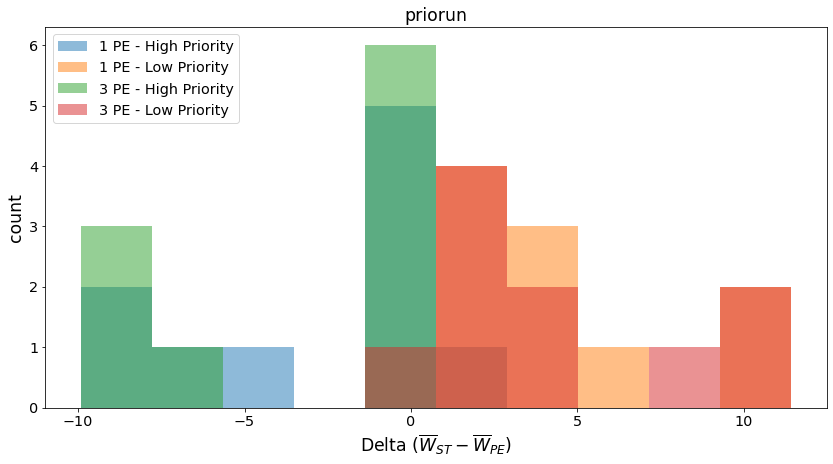

In [43]:
# # RECORD OF DIFFERENT WAYS TO PLOT HISTOGRAM

wait_table_jt_plot = (wait_table_jobtype_all
#                       .loc[wait_table_jobtype_all.job_type!='3 PE',:]
                      .copy()
                     )

jt_list = wait_table_jt_plot.job_type.unique().tolist()

x = wait_table_jt_plot.delta.values
counts, bins = np.histogram(x)

fig, ax = plt.subplots(figsize=(14,7))

for jt in jt_list:
    x = wait_table_jt_plot.loc[wait_table_jt_plot.job_type==jt,:].delta.values

    plt.hist(x, bins, alpha=0.5, label=jt)

plt.xlabel('Delta ($\overline{W}_{ST} - \overline{W}_{PE})$')
plt.ylabel('count')
plt.legend(loc='upper left')

plt.title(f"{myrun_type}")

myrun_models = f"{myrun_type}_histo_jobtype_delta"
pltpath = f'{save_image_path}/debug/{myrun_type}_{myrun_models}.png'

plt.savefig(pltpath, facecolor='w', transparent=False)

plt.show()

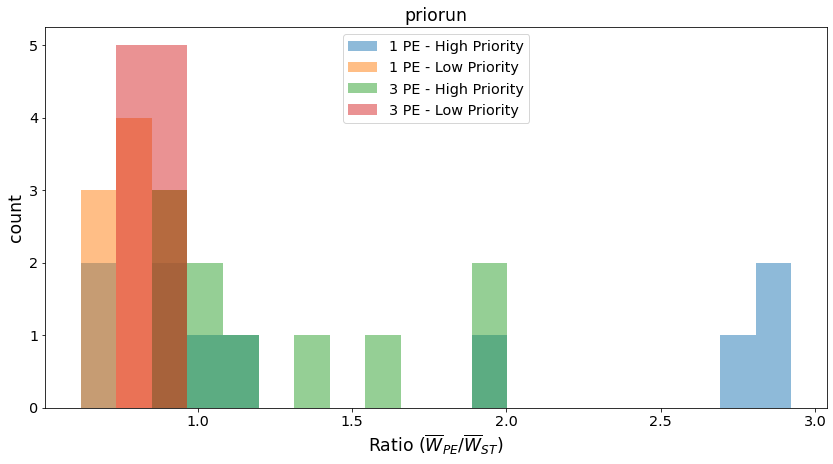

In [44]:
# # RECORD OF DIFFERENT WAYS TO PLOT HISTOGRAM

wait_table_jt_plot = (wait_table_jobtype_all
#                        .loc[wait_table_jobtype_all.job_type =='3 PE - High Priority',:]
                      .copy()
                     )

jt_list = wait_table_jt_plot.job_type.unique().tolist()

x = wait_table_jt_plot.ratio.values
counts, bins = np.histogram(x, bins=20)

fig, ax = plt.subplots(figsize=(14,7))

for jt in jt_list:
    x = wait_table_jt_plot.loc[wait_table_jt_plot.job_type==jt,:].ratio.values

    plt.hist(x, bins, alpha=0.5, label=jt)

plt.xlabel('Ratio ($\overline{W}_{PE} / \overline{W}_{ST}$)')
plt.ylabel('count')
plt.legend(loc='upper center')

plt.title(f"{myrun_type}")

myrun_models = f"{myrun_type}_histo_1fig_jobtype_ratio"
pltpath = f'{save_image_path}/debug/{myrun_type}_{myrun_models}.png'

plt.savefig(pltpath, facecolor='w', transparent=False)

plt.show()

In [45]:
# ?np.histogram(wait_table_jt_plot.ratio.values)

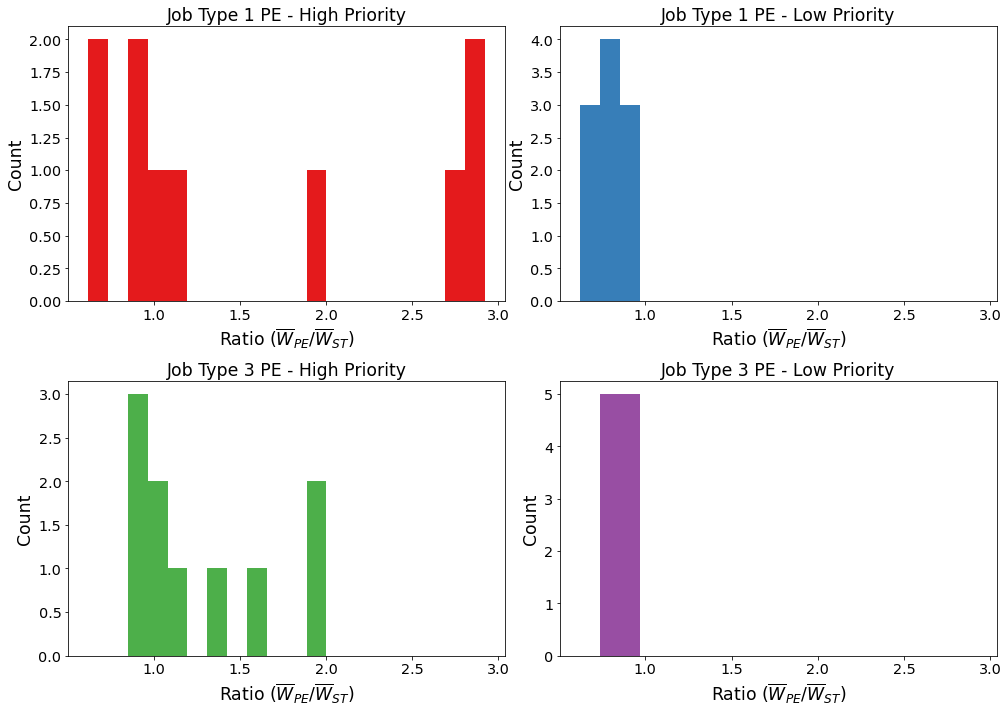

In [46]:
# Dataset

wait_table_jt_plot = (wait_table_jobtype_all
                       # .loc[wait_table_jobtype_all.job_type =='3 PE - High Priority',:]
                      .copy()
                     )

# Create a list of 4 different colors
colors = sns.color_palette('Set1', n_colors=len(jt_list))

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.subplots_adjust(hspace=0.4)

jt_list = wait_table_jt_plot.job_type.unique().tolist()

x = wait_table_jt_plot.ratio.values
counts, bins = np.histogram(x, bins=20)

for idx, jt in enumerate(jt_list):
    x = wait_table_jt_plot.loc[wait_table_jt_plot.job_type==jt,:].ratio.values
    
    # Determine the subplot coordinates
    row = idx // 2
    col = idx % 2
    
    # Plot on the corresponding subplot with the specified color and label
    axes[row, col].hist(x, bins, label=jt, color=colors[idx])
    axes[row, col].set_xlabel('Ratio ($\overline{W}_{PE} / \overline{W}_{ST}$)')
    axes[row, col].set_ylabel('Count')
    axes[row, col].set_title(f"Job Type {jt}")
#     axes[row, col].legend()
    
# # Remove the unused subplot
# if len(jt_list) < 4:
#     fig.delaxes(axes[1, 1])

# Adjust subplot spacing
plt.tight_layout()

myrun_models = f"{myrun_type}_histo_jobtype_ratio"
pltpath = f'{save_image_path}/debug/{myrun_type}_{myrun_models}.png'

plt.savefig(pltpath, facecolor='w', transparent=False)

plt.show()

In [47]:
# # RECORD OF DIFFERENT WAYS TO PLOT HISTOGRAM

# j = 0
# x = list_compare_wait[j].delta_wait
    
# # sns.histplot(list_compare_wait[j].delta_wait)
# # plt.hist(x, density=True)

# counts, bins = np.histogram(x)
# plt.bar(bins[:-1], counts, width=(bins[1]-bins[0]))
# hist(x, bins='knuth', density=True)

# # n, bins, patches = hist(x, bins="knuth", density=True) # For continues x
# # showbins = np.round(bins, 1)

# # n, bins, patches = hist(x, density=True) # For discrete x
# # showbins = bins.astype(int)

# # # centre labels
# # n_bins =len(bins)-1
# # ticks = [(patch._x0 + patch._x1)/2 for patch in patches]
# # ticklabels = [showbins[i] for i in range(n_bins)]
# # plt.xticks(ticks, ticklabels)

# plt.title(f"Run {j+1}")
# plt.show()

In [48]:
from astropy.visualization import hist
from scipy.stats import norm, t

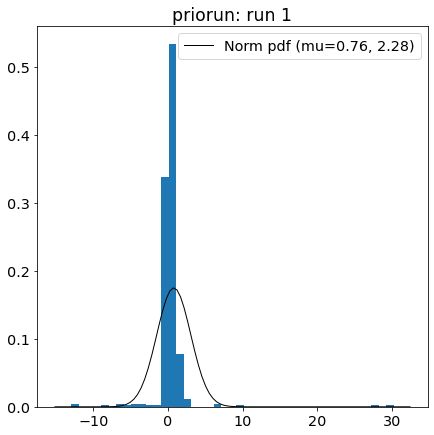

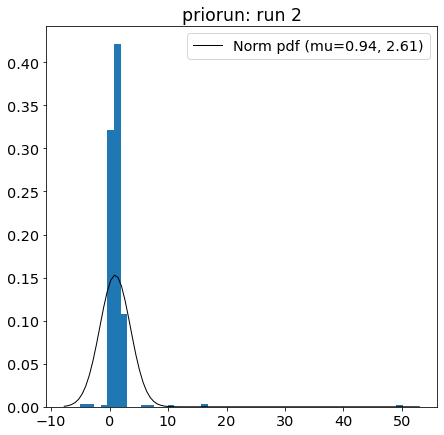

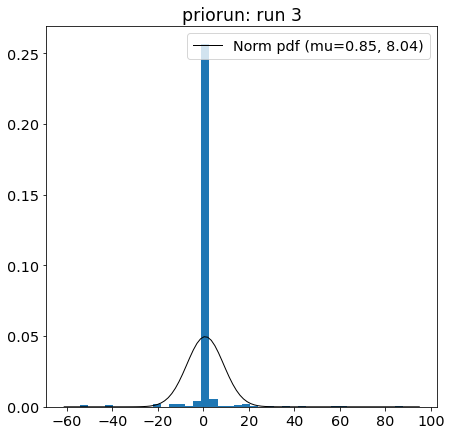

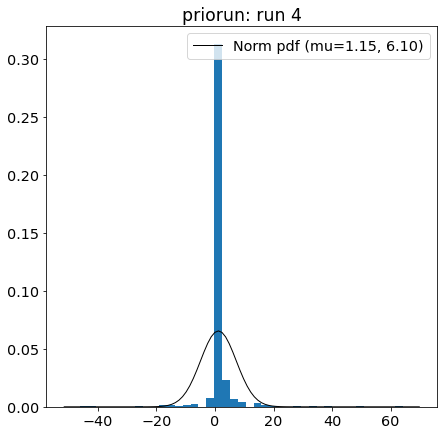

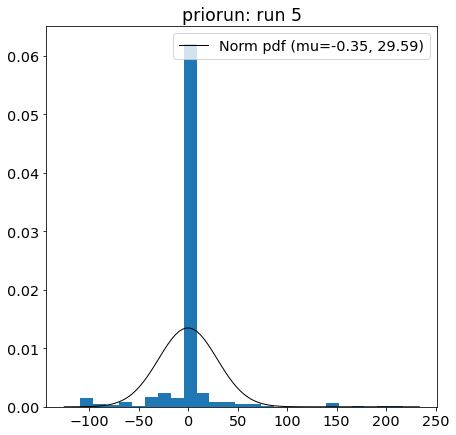

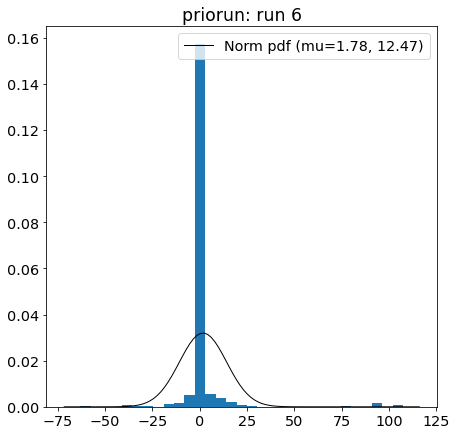

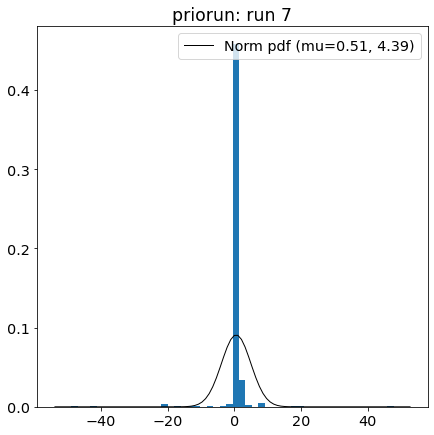

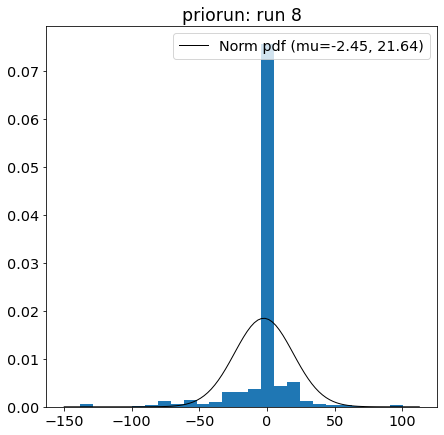

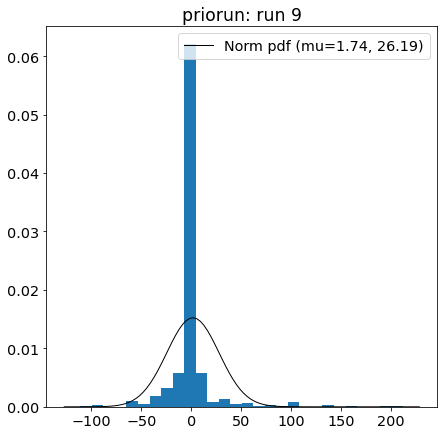

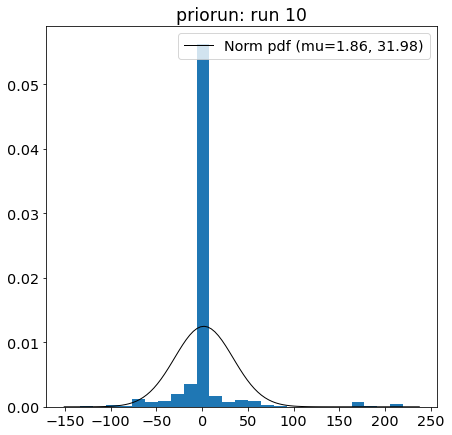

In [49]:
# Plot histogram
for j in range(10):

    fig, ax = plt.subplots(figsize=[7,7])
    
    x = list_compare_wait[j].delta_wait
    
    # sns.histplot(list_compare_wait[j].delta_wait, stat = 'density')
    n, bins, patches = hist(x, bins='scott', density=True)
#     n, bins, patches = hist(x, bins='freedman', density=True)
#     hist(x, bins="knuth", density=True)
    
    mu, std = norm.fit(x) 

    # Plot the PDF.
    xmin, xmax = plt.xlim()
    x_axis = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x_axis, mu, std)

    plt.plot(x_axis, p, 'k', linewidth=1, label=f"Norm pdf (mu={mu:.2f}, {std:.2f})")
    
    ax.legend()
    
    plt.title(f"{myrun_type}: run {j+1}")
    
    myrun_models = f"{myrun_type}_run{j+1}_wait_jitter_distrib"
    pltpath = f'{save_image_path}/debug/{myrun_shortname}_{myrun_models}.png'

    plt.savefig(pltpath, facecolor='w', transparent=False)
    
    plt.show()

In [50]:
# # Plot normalised histogram
# for j in range(10):
#     x = list_compare_wait[j].delta_wait
#     mu_x = np.mean(x)
#     sd_x = np.nanstd(x)
#     x_norm = (x - mu_x) / sd_x
    
# #     sns.histplot(list_compare_wait[j].delta_wait, stat = 'density')
#     n, bins, patches = hist(x_norm, bins='scott')
    
#     plt.title(f"Run {j+1}. Normalised with mu: {mu_x:.2f}, sd: {sd_x: .2f} ")
#     plt.show()

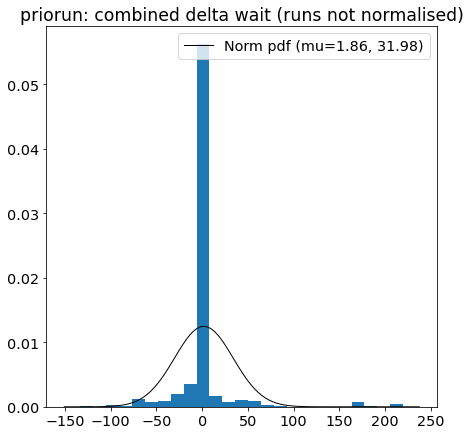

In [51]:
from scipy.stats import norm

# Plot normalised histogram
combined_x = []
for j in range(10):
    x = list_compare_wait[j].delta_wait
    mu_x = np.mean(x)
    sd_x = np.nanstd(x)
    x_norm = (x - mu_x) / sd_x
    combined_x = x
    
# Plot
fig, ax = plt.subplots(figsize=[7,7])
n, bins, patches = hist(combined_x, bins='scott', density=True, ax = ax)

# Fit a normal distribution to
# the data:
# mean and standard deviation
mu, std = norm.fit(combined_x) 

# Plot the PDF.
xmin, xmax = plt.xlim()
x_axis = np.linspace(xmin, xmax, 100)
p = norm.pdf(x_axis, mu, std)

plt.plot(x_axis, p, 'k', linewidth=1, label=f"Norm pdf (mu={mu:.2f}, {std:.2f})")

ax.legend()

plt.title(f"{myrun_type}: combined delta wait (runs not normalised)")

myrun_models = f"{myrun_type}_run{j+1}_combined_non_norm"
pltpath = f'{save_image_path}/debug/{myrun_shortname}_{myrun_models}.png'

plt.savefig(pltpath, facecolor='w', transparent=False)

plt.show()

This looks quite good ... but I am concerned that the big variance is due to big mismatches between the models. 
Well... I mean we can look at these mismatches ... to see how well they modelled stuff... 
in all likelihood it is just the the effect that stuff can go very wrong. i don't know. 
i don't have to know. it is okay. lets look at the bfsim model too. that's not my model.

In [52]:
print(f"mean : {np.mean(combined_x):.2f}")
print(f"std: {np.std(combined_x):.2f}")
print(f"median : {np.median(combined_x):.2f}")

mean : 1.86
std: 31.98
median : 1.00


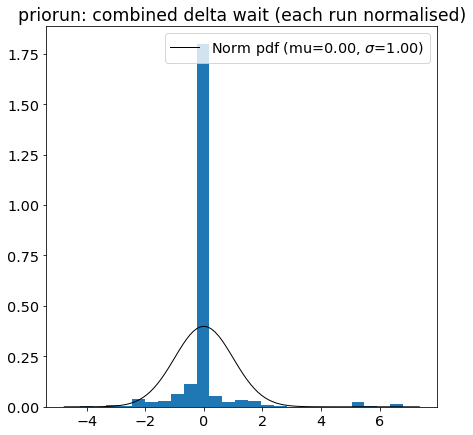

In [53]:
# Plot normalised histogram
combined_x_norm = []
for j in range(10):
    x = list_compare_wait[j].delta_wait
    mu_x = np.mean(x)
    sd_x = np.nanstd(x)
    x_norm = (x - mu_x) / sd_x
    combined_x_norm = x_norm
    
# Plot
fig, ax = plt.subplots(figsize=[7,7])
n, bins, patches = hist(combined_x_norm, bins='scott', density=True, ax = ax)

# Fit a normal distribution to
# the data:
# mean and standard deviation
mu, std = norm.fit(combined_x_norm) 

# Plot the PDF.
xmin, xmax = plt.xlim()
x_axis = np.linspace(xmin, xmax, 100)
p = norm.pdf(x_axis, mu, std)
plt.plot(x_axis, p, 'k', linewidth=1, label=f"Norm pdf (mu={mu:.2f}, $\sigma$={std:.2f})")

# T distribution
# t_df, t_loc, t_scale = t.fit(combined_x_norm)
# p_t = t.pdf(x_axis, t_df, loc=t_loc, scale=t_scale)
# plt.plot(x_axis, p_t, 'b', linewidth=1, label=f"T pdf (df={t_df:.2f}, loc={t_loc:.2f}, scale={t_scale:.2f}")

ax.legend()

plt.title(f"{myrun_type}: combined delta wait (each run normalised)")

myrun_models = f"{myrun_type}_run{j+1}_combined_norm"
pltpath = f'{save_image_path}/debug/{myrun_shortname}_{myrun_models}.png'

plt.savefig(pltpath, facecolor='w', transparent=False)

plt.show()

In [54]:
print(f"mean : {np.mean(combined_x_norm)}")
print(f"std: {np.std(combined_x_norm)}")

mean : 2.1316282072803006e-17
std: 0.9999999999999999


### Average Waiting time plots

In [55]:
# ?sns.catplot
# ?sns.relplot

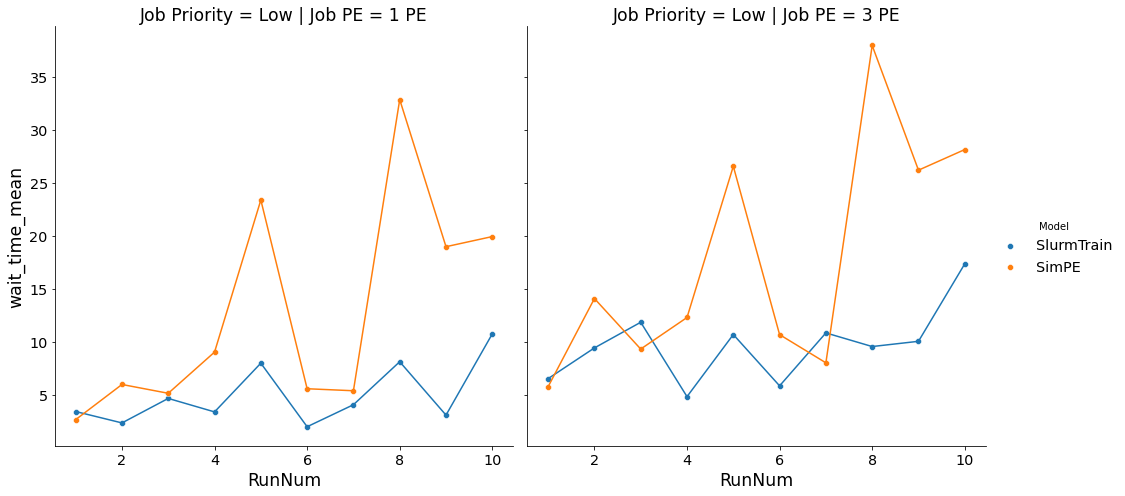

In [56]:
# Job Priority Graph

fg = sns.FacetGrid(df_plot_fifo, 
                    hue = "Model",
                    row = "Job Priority",
                    col = "Job PE",
                    height = 7
                  )

fg.map(sns.scatterplot, "RunNum", "wait_time_mean")
fg.map(sns.lineplot, "RunNum", "wait_time_mean")
fg.add_legend()

plt.show()

In [57]:
# WTF IS GOING ON HERE !!
# THESE SHOULD BE MATCHING!!!!!

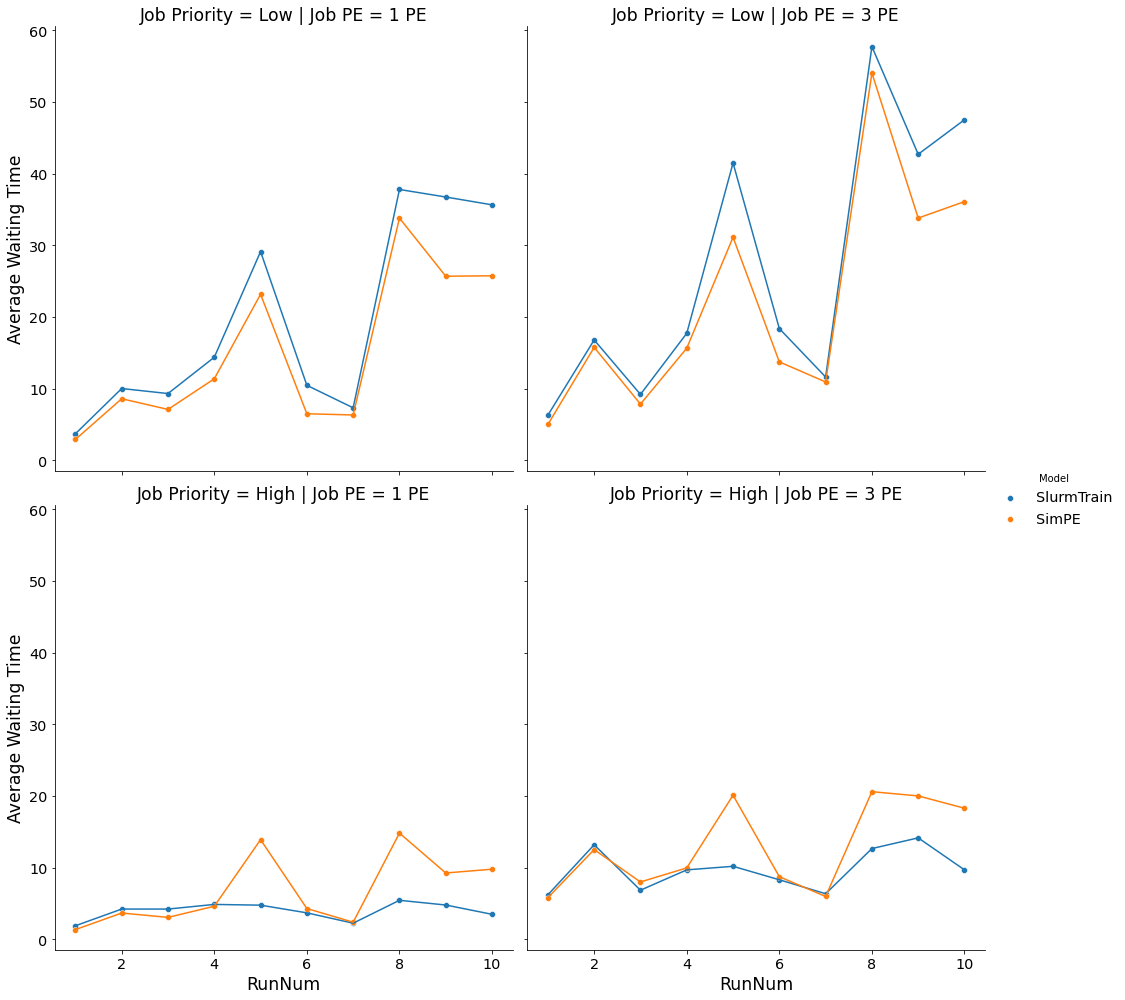

In [58]:
fg = sns.FacetGrid(df_plot_prio, 
                    hue = "Model",
                    row = "Job Priority",
                    col = "Job PE",
                    height = 7,
                    
                  )

fg.map(sns.scatterplot, "RunNum", "wait_time_mean")
fg.map(sns.lineplot, "RunNum", "wait_time_mean")

fg.add_legend()

fg.set_ylabels("Average Waiting Time")

myrun_models = "slurmtrain_simpe"
pltpath = f'{save_image_path}/{myrun_shortname}_{myrun_models}.png'

plt.savefig(pltpath, facecolor='w', transparent=False)

plt.show()

In [59]:
df_plot.query("RunNum == 10 and job_prio == 1 and Model == 'SlurmTrain'")

,job_prio,job_pe_req,wait_time_mean,run_time_mean,job_number_count,Total_run_backfills,RunNum,Model,SchedType,backfill_sum,Job PE,Job Priority
0,1,1,10.736842,33.105263,95,0,10,SlurmTrain,FIFO,NaN,1 PE,Low
1,1,3,17.352381,33.342857,105,0,10,SlurmTrain,FIFO,NaN,3 PE,Low
0,1,1,35.664000,33.808000,125,0,10,SlurmTrain,Priority,NaN,1 PE,Low
1,1,3,47.537879,30.401515,132,0,10,SlurmTrain,Priority,NaN,3 PE,Low


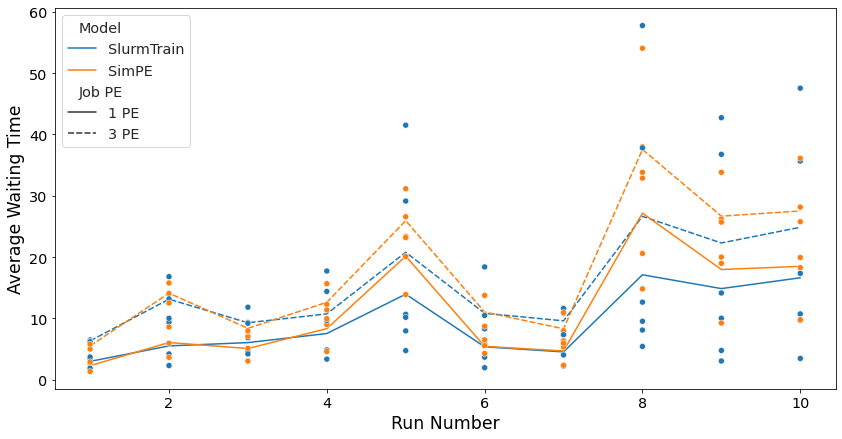

In [60]:
# Lets show this on one graph

fig, ax =plt.subplots(figsize=(14,7))

sns.set_style("ticks", {'axes.grid' : True})

p1 = sns.scatterplot(data=df_plot, 
                     x = "RunNum",
                     y = "wait_time_mean",
                     hue="Model",
                     ax = ax,
                     zorder = 10,
                     legend = None,
                     palette="tab10"
                     )

p2 = sns.lineplot(data=df_plot,
                  x = "RunNum",
                  y = "wait_time_mean",
                  hue = "Model",
                  style = "Job PE",
#                   style_order = (3,1),
                  ci = None,
                  palette="tab10",
                  ax = ax)

plt.xlabel("Run Number")
plt.ylabel("Average Waiting Time")

plt.show()

In [61]:
# TWO GRAPHS: 
# SLURMSIM VS SLURMTRAIN
# FIFO VS BF  -> wys backfills speed up 

NameError: name 'df_plot_no8' is not defined

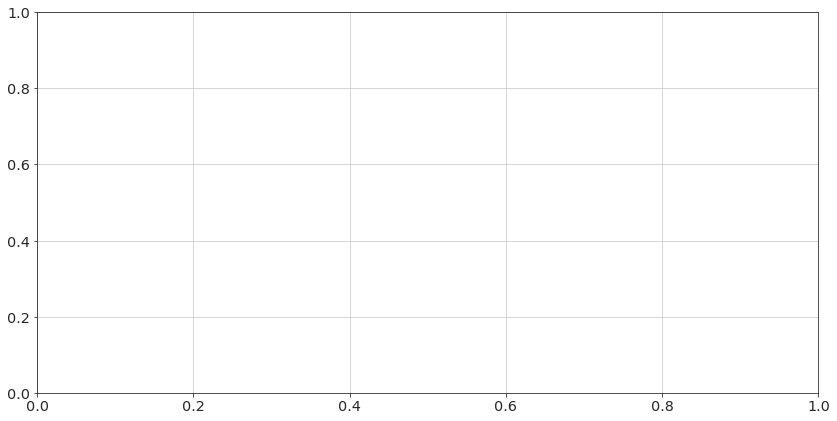

In [62]:
# No 8 version

import matplotlib.pyplot as plt
import seaborn as sns

fig, ax =plt.subplots(figsize=(14,7))

sns.set_style("ticks", {'axes.grid' : True})

p1 = sns.scatterplot(data=df_plot_no8, 
                     x = "RunNum",
                     y = "wait_time_mean",
                     hue="Model",
                     ax = ax,
                     zorder = 10,
                     legend = None,
                     palette="tab10"
                     )

p2 = sns.lineplot(data=df_plot_no8,
                  x = "RunNum",
                  y = "wait_time_mean",
                  hue = "Model",
                  style = "Job PE",
#                   style_order = (3,1),
                  ci = None,
                  palette="tab10",
                  ax = ax)

plt.xlabel("Run Number")
plt.ylabel("Average Waiting Time")

plt.show()

In [ ]:
# IDEA FOR FOLLOW UP GRAPH :  actual running times of jobs vs expected times ... 

#### Volgende probeerslae

In [ ]:
# ?sns.catplot
# ?sns.relplot

In [ ]:
sns.relplot(data=df_plot, 
            x = "job_prio")

In [ ]:
# Plot the wait times over the 10 runs

import matplotlib.pyplot as plt
import seaborn as sns

# Set a grid layout
sns.set_style("ticks", {'axes.grid' : True})

g = sns.FacetGrid(df_plot, 
                  col="Model", 
                  hue="Model", 
                  height=7, 
                  aspect=1, 
                  palette="tab10")

# # Draw line plot
# g.map(sns.lineplot, 
#       "RunNum", 
#       "wait_time_mean",
#       ci = None)

# Draw scatter plots (dot plots) with circle markers
g.map(sns.scatterplot, 
      "RunNum", 
      "wait_time_mean", 
      "Job PE",
      edgecolor=None, 
      marker="o")

# Add a legend
g.add_legend()

# Set plot title and labels
g.set_axis_labels("Run Number", "Average Waiting Time")
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Difference in Average Waiting Time between SimPE and SlurmTrain for Backfill Jobs')

plt.show()

In [ ]:
from plotnine import ggplot, aes, geom_point, geom_line, theme_light, facet_wrap

p = (
    ggplot(df_plot) +
    geom_point(aes("RunNum", "wait_time_mean", colour="Job PE")) + 
    theme_light() + 
    facet_wrap("Model")
)

p

In [ ]:
# from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap
# from plotnine.data import mtcars

# (ggplot(mtcars, aes("wt", "mpg", color="factor(gear)"))
#  + geom_point()
#  + stat_smooth(method="lm")
#  + facet_wrap("~gear"))

In [ ]:
# Plot the wait times over the 10 runs

import matplotlib.pyplot as plt
import seaborn as sns

# Set a grid layout
sns.set_style("ticks", {'axes.grid' : True})

g = sns.FacetGrid(df_plot, 
                  col="Job PE", 
                  hue="Model", 
                  height=7, 
                  aspect=1, 
                  palette="tab10")

# Draw line plot
g.map(sns.lineplot, "RunNum", "wait_time_mean")

# Draw scatter plots (dot plots) with circle markers
g.map(sns.scatterplot, "RunNum", "wait_time_mean", 
      s=100, 
      edgecolor=None, 
      marker="o")

# Add a legend
g.add_legend()

# Set plot title and labels
g.set_axis_labels("Run Number", "Average Waiting Time")
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Difference in Average Waiting Time between SimPE and SlurmTrain for FIFO Jobs')

plt.show()

In [ ]:
sns.relplot(data = df_plot,
            x="RunNum",
            y="wait_time_mean",
#              col = "Job PE",
            size = "Job PE",
            sizes = (50,200),
            hue="Model",
            height=7,
            aspect=1,
            kind = "scatter"
            )

plt.show()

In [ ]:
# Create a scatter plot
plt.figure(figsize=(14, 7))

sns.set_style("ticks", {'axes.grid' : True})
sns.scatterplot(x="RunNum", 
                y="wait_time_mean", 
                hue="Model", 
                size="Job PE", 
                sizes=(50, 200), 
                data=df_plot, 
                palette="tab10", 
                edgecolor=None, marker="o")

# Set plot title and labels
plt.title('Average Waiting Time for Different Run Types over Runs')
plt.xlabel('Run Number')
plt.ylabel('Average Waiting Time')

# Add a legend
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [ ]:
# Create a scatter plot
plt.figure(figsize=(14, 7))

scatter = sns.scatterplot(x="RunNum", 
                          y="wait_time_mean", 
                          hue="Model", 
                          size="Job PE", 
                          sizes=(50, 200), 
                          data=df_plot, 
                          palette="tab10", 
                          edgecolor=None, 
                          marker="o")

# Set plot title and labels
plt.title('Average Waiting Time for Different Run Types over Runs')
plt.xlabel('Run Number')
plt.ylabel('Average Waiting Time')

# Handle the legend: split it into two parts
handles, labels = scatter.get_legend_handles_labels()

# Show legend for RunType
legend1 = plt.legend(handles=handles[1:3], labels=labels[1:3], title="RunType", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., handletextpad=0.1)
plt.gca().add_artist(legend1)

# Show legend for job_pe_req
plt.legend(handles=handles[3:], labels=labels[3:], title="", bbox_to_anchor=(1.05, 0.5), loc=2, borderaxespad=0., handletextpad=0.1)

plt.show()

## Junk

In [ ]:
# rng = np.random.default_rng()
# rng

In [ ]:
# # T-test example

# rvs1 = stats.expon.rvs(loc=10,size=100,random_state=rng)
# rvs2 = (rvs1stats.expon.rvs(loc=10,size=100,random_state=rng)
#        )
#         # rvs1[1] = np.nan
# a = stats.ttest_rel(rvs1, rvs2)

# print(a.statistic)
# print(a.pvalue)

In [ ]:
rvs1

In [ ]:
rvs2

In [ ]:
# %run ./srun8_slurmtrain.ipynb